# Models

## Common Code

Common functions for training and fine-tuning the BERT models.

In [16]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
print("INIT module_path: ", module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

DATA_DIR = module_path + "/data"
MODEL_DIR = module_path + "/model"

for data_dir in [DATA_DIR, MODEL_DIR]:
    os.makedirs(data_dir, exist_ok=True)

INIT module_path:  c:\Users\Alan\Desktop\Open_Source\BERT-TLSA-paper


In [ ]:
from transformers import AutoModelForMaskedLM, AutoModel, DistilBertConfig, PreTrainedModel, AutoTokenizer
import torch.utils.data as tdata
import torch
import torch.nn as nn
from typing import cast

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


class BERTSentimentClassifier(nn.Module):
    def __init__(self, bert: AutoModel, n_classes: int, dropout_prob: float = 0.3):
        super().__init__()
        self.bert = bert
        self.pre_classifier = nn.Linear(bert.config.hidden_size, bert.config.hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.classifier = nn.Linear(bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids: torch.IntTensor, attention_mask: torch.IntTensor) -> torch.FloatTensor:
        hidden_state = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            return_dict=False
        )[0]
        # https://huggingface.co/transformers/v3.2.0/model_doc/bert.html
        # Pooler output is last layer of hidden state for [CLS] token, whose
        # output is fed through a linear layer and a tanh function
        #
        # Shape of (batch_size, hidden_size) 
        pooled_output: torch.FloatTensor = hidden_state[:, 0, :] # (batch_size, hidden_size)
        pooled_output = self.pre_classifier(pooled_output) # (batch_size, hidden_size)
        pooled_output = self.relu(pooled_output) # (batch_size, hidden_size)
        pooled_output = self.dropout(pooled_output) # (batch_size, hidden_size)
        logits = self.classifier(pooled_output) # (batch_size, n_classes)
        return logits


class TrainingConfig:
    def __init__(self, tokenizer: AutoTokenizer = None, pretrained_tokenizer_name: str = "bert-base-uncased", pretrained_model_name: str = "", stop_delta: float = 0.01, stop_patience: int = 5, name: str = "model", train_bert_in_finetune: bool = True, max_token_length: int = 512, class_names: list[str] = ["negative", "neutral", "positive"]):
        if tokenizer != None:
            self.tokenizer = tokenizer
        else:
            self.tokenizer = AutoTokenizer.from_pretrained(pretrained_tokenizer_name)
        
        # ---------- Config data ---------- #
        self.pretrained_model_name = pretrained_model_name
        self.name = name
        # Number of output classes
        self.class_names = class_names
        # How much of a delta counts as an improvement. See TrainEarlyStopping.
        self.stop_delta = stop_delta
        # Number of epochs to wait for an improvement before stopping training. See TrainEarlyStopping.
        self.stop_patience = stop_patience
        # Whether to include the base bert parameters in finetuning
        # This increases training time, but could potentially lead to better performance
        self.train_bert_in_finetune = train_bert_in_finetune
        self.max_token_length = max_token_length
        
        # ---------- Runtime data ---------- #
        # The final pretrained model, after pretraining
        self.pretrained_model = cast(AutoModel, None)
        self.pretrained_dataloaders = cast(tuple[tdata.DataLoader, tdata.DataLoader, tdata.DataLoader], None)
        # The final classifier model, after finetuning
        self.finetuned_classifier_model = cast(BERTSentimentClassifier, None)
        self.finetuned_dataloaders = cast(tuple[tdata.DataLoader, tdata.DataLoader, tdata.DataLoader], None)

    def __str__(self):
        return str(self.__dict__)
    
    def __repr__(self):
        return str(self)


print(f"Training on device: {device}")

Training on device: cuda


In [38]:
from transformers import AutoTokenizer
import pandas as pd
import torch
from typing import TypedDict, cast, Protocol
import numpy as np
import seaborn as sns
import os
import torch
import tempfile


def atomic_torch_save(obj, path: str):
    """
    Saves obj to a temp file during the writing process,
    and then replaces the original file with the new file if
    the save is successful.

    If the save is interrupted mid-way (such as by a KeyboardInterrupt),
    the original file remains unharmed.
    """
    dir_name = os.path.dirname(path)
    with tempfile.NamedTemporaryFile(dir=dir_name, delete=False) as tmp_file:
        temp_path = tmp_file.name
    try:
        torch.save(obj, temp_path)
        os.replace(temp_path, path)  # atomic on most OSes
    except Exception as e:
        if os.path.exists(temp_path):
            os.remove(temp_path)
        raise e


def move_dict_to(res: dict, device: torch.device):
    for key in res:
        if isinstance(res[key], torch.Tensor):
            res[key] = cast(torch.Tensor, res[key]).to(device=device)


class TokenizedInputs(TypedDict):
    input_ids: torch.IntTensor
    attention_mask: torch.IntTensor
    labels: torch.IntTensor


class MaskedTextDatasetItem(TokenizedInputs):
    original_text: str


class MaskedTextDataset(torch.utils.data.Dataset[MaskedTextDatasetItem]):
    """
    Dataset of masked text
    """
    def __init__(self, encodings: TokenizedInputs = None, original_text: list[str] = None, batch_device: torch.device = None):
        self.encodings = encodings
        self.original_text = original_text
        self.batch_device = batch_device

    def __getitem__(self, index: int) -> MaskedTextDatasetItem:
        # Return the dictionary just like encodings, except it only
        # contains the entries for a specific row (sentence)
        res = {key: val[index] for key, val in self.encodings.items() }
        if self.original_text:
            res["original_text"] = self.original_text[index]
        # If output_device is set, we move individual batches to the device
        if self.batch_device:
            move_dict_to(res, self.batch_device)
        return res
    
    def __len__(self):
        return len(self.encodings["input_ids"])
    
    def save_dict(self) -> dict:
        save = {}
        for key in ["encodings", "original_text"]:
            save[key] = getattr(self, key)
        return save
    
    def load_dict(self, save: dict):
        for key in save:
            setattr(self, key, save[key])


class ReviewsDatasetItem(TokenizedInputs):
    original_text: str
    score: int


class ReviewsDataset(torch.utils.data.Dataset[ReviewsDatasetItem]):
    """
    Dataset of reviews and their normaliezd scores (decimal number from 0 to 1)
    """
    def __init__(self, encodings: TokenizedInputs = None, scores: list[int] = None, max_score: int = 0, original_text: list[str] = None, batch_device: torch.device = None):
        self.encodings = encodings
        self.scores = scores
        self.max_score = max_score
        self.original_text = original_text
        self.batch_device = batch_device
    
    def __getitem__(self, index: int) -> ReviewsDatasetItem:
        # Return the dictionary just like encodings, except it only
        # contains the entries for a specific row (sentence)
        res = {key: val[index] for key, val in self.encodings.items() }
        if self.original_text:
            res["original_text"] = self.original_text[index]
        if self.scores[index] < 0 or self.scores[index] >= 3:
            display(self.scores)
            return
        res["score"] = self.scores[index]
        # If output_device is set, we move individual batches to the device
        if self.batch_device:
            move_dict_to(res, self.batch_device)
        return res

    def __len__(self):
        return len(self.encodings["input_ids"])
    
    def save_dict(self) -> dict:
        save = {}
        for key in ["encodings", "scores", "max_score", "original_text"]:
            save[key] = getattr(self, key)
        return save
    
    def load_dict(self, save: dict):
        for key in save:
            setattr(self, key, save[key])


def get_masked_dataset(tokenizer: AutoTokenizer, review_texts: list[str], percent_masked: float = 0.15, max_token_length: int = 512, dataset_file: str = "", batch_device: torch.device = None) -> MaskedTextDataset:
    print("Loading masked dataset:")
    if dataset_file:
        print(f"    Loading existing dataset file @ {dataset_file}...")
        # Check if dataset file exists — if so, then load from file
        try:
            # Disable weights_only since we are loading aribitrary python classes
            masked_text_dataset = MaskedTextDataset()
            masked_text_dataset.load_dict(torch.load(f"{DATA_DIR}/{dataset_file}", weights_only=False))
            return masked_text_dataset
        except Exception as e:
            print(f"    Error loading dataset file: {e}")
    print(f"    Creating new dataset file @ {dataset_file}...")
    encodings: TokenizedInputs = tokenizer(review_texts, 
      add_special_tokens=True,
      max_length=max_token_length,
      truncation=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    # Create a new field labels that is a clone of input_ids
    encodings["labels"] = encodings["input_ids"].detach().clone()
    # In BERT paper, each token has 15% chance of being masked
    # First, create random vector that spans all of the input_ids (spans all the tokens)
    rand = torch.rand(encodings["input_ids"].shape)
    # (rand < 0.15) -> Any token that has a corresponding random value of < 0.15, we mask
    # We also don't want to mask special tokens (101, 102), and padding tokens (0)
    # * operator is elementwise multiplication, which is same as AND for boolean tensors
    mask_arr = (rand < percent_masked) * (encodings["input_ids"] != 101) * (encodings["input_ids"] != 0) * (encodings["input_ids"] != 102)
    # Stores all the indices that we want to mask
    masked_cols = []
    # Iterate over each row in the mask_arr (basically each sentence in our text data)
    for i in range(mask_arr.shape[0]):
        # .nonzero() -> finds the indicies where we have "true" values (since true = 1 and false = 0 in pytorch)
        masked_cols.append(mask_arr[i].nonzero().flatten().tolist())
    # Apply our mask_arr in each row (each sentence)
    for i in range(mask_arr.shape[0]):
        # Special Tensor syntax -> we can pass in a list of indicies for any of the axes
        #   In this case, we pass in a list of indices in the column axis, to effectively
        #   select the columns (tokens) we want to mask out
        encodings["input_ids"][i, masked_cols[i]] = 103
    masked_text_dataset = MaskedTextDataset(encodings, review_texts, batch_device=batch_device)
    if dataset_file:
        atomic_torch_save(masked_text_dataset.save_dict(), f"{DATA_DIR}/{dataset_file}")
    return masked_text_dataset


def get_reviews_dataset(tokenizer: AutoTokenizer, review_scores: list[float], max_score: int, review_texts: list[str], max_token_length: int = 512, dataset_file: str = "", batch_device: torch.device = None) -> ReviewsDataset:
    print("Loading reviews dataset:")
    if dataset_file:
        print(f"    Loading existing dataset file @ {dataset_file}...")
        # Check if dataset file exists — if so, then load from file
        try:
            # Disable weights_only since we are loading aribitrary python classes
            reviews_dataset = ReviewsDataset()
            reviews_dataset.load_dict(torch.load(f"{DATA_DIR}/{dataset_file}", weights_only=False))
            return reviews_dataset
        except Exception as e:
            print(f"    Error loading dataset file: {e}")
    encodings: TokenizedInputs = tokenizer(review_texts, 
      add_special_tokens=True,
      max_length=max_token_length,
      truncation=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    reviews_dataset = ReviewsDataset(encodings, review_scores, max_score, review_texts, batch_device=batch_device)
    print(f"    Creating new dataset file @ {dataset_file}...")
    if dataset_file:
        atomic_torch_save(reviews_dataset.save_dict(), f"{DATA_DIR}/{dataset_file}")
    return reviews_dataset

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm
from transformers.modeling_outputs import MaskedLMOutput
from typing import cast, Iterator
import matplotlib.pyplot as plt
import itertools
from typing import TypeVar, Generic, Protocol
import torch.utils.data as tdata
import sklearn.model_selection as skms
import math
import torch
from typing import Callable, Union, Iterable
import torch.nn as nn
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup


TDataset = TypeVar('TDataset', bound=tdata.Dataset)
class TrainDatasetSplit(Generic[TDataset]):
    def __init__(self, train: tdata.Subset[TDataset], test: tdata.Subset[TDataset], valid: tdata.Subset[TDataset]):
        self.train = train
        self.test = test
        self.valid = valid
    
    def get_dataloaders(self, batch_size: int = None, shuffle: bool = None, drop_last: bool = False) -> tuple[tdata.DataLoader, tdata.DataLoader, tdata.DataLoader]:
        return (tdata.DataLoader(self.train, shuffle=shuffle, batch_size=batch_size, drop_last=drop_last), \
                tdata.DataLoader(self.test, shuffle=shuffle, batch_size=batch_size, drop_last=drop_last), \
                tdata.DataLoader(self.valid, shuffle=shuffle, batch_size=batch_size, drop_last=drop_last))


def train_split_dataset(dataset: TDataset, train_percent: float = 0.7, test_percent: float = 0.2, validate_percent: float = 0.1, random_state: int = None) -> TrainDatasetSplit[TDataset]:
    assert math.isclose(train_percent + test_percent + validate_percent, 1.0), "Expected train_percent + test_percent + validate_percent = 1.0!"
    dataset_indices = list(range(len(dataset)))
    test_train_indices, valid_indicies = skms.train_test_split(dataset_indices, test_size=validate_percent, random_state=random_state)
    train_indicies, test_indicies = skms.train_test_split(test_train_indices, test_size=test_percent/(train_percent + test_percent), random_state=random_state)
    valid = tdata.Subset(dataset, valid_indicies)
    train = tdata.Subset(dataset, train_indicies)
    test = tdata.Subset(dataset, test_indicies)
    split = TrainDatasetSplit(train=train, test=test, valid=valid)
    return split


class RunLoopIterData:
    is_valid: bool

    output_loss: torch.FloatTensor
    output_num_correct: int
    output_y_preds: torch.IntTensor
    output_y_tests: torch.IntTensor

    def reset(self, is_valid: bool = False):
        self.output_loss = None
        self.output_num_correct = None
        self.output_y_preds = None
        self.output_y_tests = None
        self.is_valid = is_valid
    
    def postfix(self) -> dict:
        return {
            "loss": self.output_loss.item(),
            "num_correct": self.output_num_correct
        }


class RunLoopStats:
    total_loss: float
    total_correct: int
    average_loss: float
    accuracy: float
    
    y_preds_arr: list[torch.FloatTensor]
    y_tests_arr: list[torch.FloatTensor]
    y_preds_stack: torch.FloatTensor
    y_tests_stack: torch.FloatTensor

    def __init__(self):
        self.reset()

    def reset(self):
        self.total_loss = cast(float, None)
        self.total_correct = cast(int, None)
        self.average_loss = cast(float, 0)
        self.accuracy = cast(float, 0)
        self.y_preds_arr = []
        self.y_tests_arr = []
        self.y_preds_stack = None
        self.y_tests_stack = None
    
    def add_iter_data(self, output: RunLoopIterData):
        def get_raw_value(val: Union[float, torch.FloatTensor]):
            if torch.is_tensor(val):
                return val.item()
            return val
        if output.output_loss:
            if self.total_loss == None:
                self.total_loss = 0
            self.total_loss += get_raw_value(output.output_loss)
        if output.output_num_correct:
            if self.total_correct == None:
                self.total_correct = 0
            self.total_correct += get_raw_value(output.output_num_correct)
        if output.output_y_preds:
            self.y_preds_arr.append(output.output_y_preds)
        if output.output_y_tests:
            self.y_tests_arr.append(output.output_y_tests)

    def calculate(self, batch_count: int, items_count: int):
        self.average_loss = self.total_loss / batch_count if self.total_loss else None
        self.accuracy = self.total_correct / items_count if self.total_correct else None
        if len(self.y_preds_arr) > 0:
            self.y_preds_stack = torch.stack(self.y_preds_arr).cpu()
        if len(self.y_tests_arr) > 0:
            self.y_tests_stack = torch.stack(self.y_tests_arr).cpu()


class TrainEarlyStopping:
    def __init__(self, patience: int = 5, delta: float = 0.05):
        """
        patience = # epochs we wait for improvement
        delta = minimmum decrease in loss in order to count as an improvement
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False

    def check_early_stop(self, val_loss: Union[float, Iterable[float]]) -> bool:
        try:
            # Assume val_loss = iterable, and bail if it doesn't work
            for elem in val_loss:
                if self.check_early_stop(elem):
                    return True
            return False
        except TypeError:
            pass
        
        # Handle val_loss = float
        if self.stop_training:
            # Once we stopped training, we halt any further checks
            return True
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            # If we don't have a best loss yet, OR
            # we got a new loss that is better than our delta
            #
            # then we reset the no improvement counter
            self.best_loss = val_loss
            self.no_improvement_count = 0
        else:
            # Otherwise, we didn't improve
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                # If we didn't improve over patience (num of epochs we wait for improvements)
                # then we stop
                self.stop_training = True
        return self.stop_training


def get_log_data_fig(log_data: list[dict]):
    fig = plt.figure()
    if len(log_data) > 0:
        epochs = [x["epoch"] for x in log_data]
        for key in log_data[0]:
            if key.startswith("_") or key == "epoch" or log_data[0][key] == None:
                continue
            plt.plot(epochs, [item[key] for item in log_data], label=key)
        plt.legend()
    else:
        plt.plot([0], [0], label="empty")
    plt.close()
    return fig


TDatasetItem = TypeVar('TItem')
TModel = TypeVar('TModel', bound=nn.Module)
RunModelFn = Callable[[TModel, TDatasetItem, RunLoopIterData], None]
def train_from_dataloader(model: nn.Module, optim: torch.optim.Optimizer, dataloader: tdata.DataLoader[TDatasetItem], run_fn: RunModelFn, epoch: int = None, scheduler: torch.optim.lr_scheduler.LRScheduler = None) -> RunLoopStats:
    """
    Trains a model on the batches from a dataloader, and returns stats about the run.
    """
    loop = tqdm(cast(Iterator[MaskedTextDatasetItem], dataloader), leave=True)
    if epoch != None:
        loop.set_description(f"Epoch: {epoch: <4}")
    train_stats = RunLoopStats()
    model.train()
    loop_iter_data = RunLoopIterData()
    for data in loop:
        loop_iter_data.reset(is_valid=False)

        run_fn(model, data, loop_iter_data)
        loss = loop_iter_data.output_loss
        
        # Apply backward propagation
        loss.backward()
        # Clip gradients to limit oscillations
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optim.step()
        if scheduler:
            scheduler.step()
        # Reset gradient
        optim.zero_grad()

        # Set info in tqdm progress bar
        loop.set_postfix(loop_iter_data.postfix())
        train_stats.add_iter_data(loop_iter_data)
    train_stats.calculate(batch_count=len(dataloader), items_count=len(dataloader.dataset))
    return train_stats


def eval_from_dataloader(model: nn.Module, dataloader: tdata.DataLoader[TDatasetItem], run_fn: RunModelFn) -> RunLoopStats:
    """
    Runs a model on the batches from a dataloader, and returns stats about the run.
    """
    loop = tqdm(cast(Iterator[MaskedTextDatasetItem], dataloader), leave=True)
    loop.set_description(" " * 11)
    valid_stats = RunLoopStats()
    model.eval()
    loop_iter_data = RunLoopIterData()
    with torch.no_grad():
        for data in loop:
            loop_iter_data.reset(is_valid=True)

            run_fn(model, data, loop_iter_data)

            # Set info in tqdm progress bar
            loop.set_postfix(loop_iter_data.postfix())
            valid_stats.add_iter_data(loop_iter_data)
    valid_stats.calculate(batch_count=len(dataloader), items_count=len(dataloader.dataset))
    return valid_stats


def train_loop(name: str, desc: str, model_filename: str, train_dataloader: tdata.DataLoader[TDatasetItem], valid_dataloader: tdata.DataLoader[TDatasetItem], model: TModel, optim: torch.optim.Optimizer, stop_patience: int, stop_delta: float, run_fn: RunModelFn, scheduler: torch.optim.lr_scheduler.LRScheduler = None):
    """
    Trains a model in a loop until it no longer improves, based on stop_patience and stop_delta.
    See TrainEarlyStopping for more information.
    """
    log_data: list[dict] = []
    init_epoch = 0
    prev_valid_loss = None
    early_stop = TrainEarlyStopping(patience=stop_patience, delta=stop_delta)

    model_dir = f"{MODEL_DIR}/{name}/"
    os.makedirs(model_dir, exist_ok=True)

    model_file_path = model_dir + model_filename + ".pt"
    if os.path.exists(model_file_path):
        # If model file exist, then try to continue off of where it left off
        data = torch.load(model_file_path, weights_only=False, map_location=device)
        model.load_state_dict(data["model"])
        optim.load_state_dict(data["optim"])
        init_epoch = data["log_data"][-1]["epoch"] + 1
        log_data = data["log_data"]
        prev_valid_loss = log_data[-1]["valid_loss"]
        print("")
        print(f"Resuming existing model at epoch: {init_epoch}, data: {log_data[-1]}")
        # Resimulate the early stop checker using all of the log data
        # and bail if we have stopped
        if early_stop.check_early_stop([x["valid_loss"] for x in log_data]):
            return
        # Otherwise, continue training

    print(f"Training start for '{name}' {desc}...")
    log_data_display_handle = display(display_id=True)
    log_data_display_handle.update(get_log_data_fig(log_data))
    epoch_loop = itertools.count(start=init_epoch, step=1)
    for epoch in epoch_loop:
        # Training loop
        train_stats = train_from_dataloader(model=model, optim=optim, dataloader=train_dataloader, run_fn=run_fn, epoch=epoch, scheduler=scheduler)
        
        # Validation loop
        valid_stats = eval_from_dataloader(model=model, dataloader=valid_dataloader, run_fn=run_fn)
        
        # Log data
        log_data.append({
            "epoch": epoch,
            "train_loss": train_stats.average_loss,
            "valid_loss": valid_stats.average_loss,
            "valid_accuracy": valid_stats.accuracy
        })
        print(f"{' ' * 11}{str(log_data[-1])}")

        # Make plot
        fig = get_log_data_fig(log_data)
        log_data_display_handle.update(fig)


        # Overwrite the model if there's an improvement
        if prev_valid_loss != None and valid_stats.average_loss < prev_valid_loss:
            atomic_torch_save({
                "model": model.state_dict(),
                "optim": optim.state_dict(),
                "log_data": log_data,
            }, model_file_path)
        prev_valid_loss = valid_stats.average_loss

        # Break if our moving validation delta loss average is smaller than our stop_delta_loss
        if early_stop.check_early_stop(valid_stats.average_loss):
            print("Stopping early...")
            break


def pretraining_loop(train_dataloader: tdata.DataLoader[MaskedTextDatasetItem], valid_dataloader: tdata.DataLoader[MaskedTextDatasetItem], config: TrainingConfig):
    """
    Trains the base BERT model using MLM
    """
    def train_fn(model: AutoModelForMaskedLM, data: MaskedTextDatasetItem, iter_data: RunLoopIterData) -> torch.FloatTensor:
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)

        outputs: MaskedLMOutput = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        iter_data.output_loss = outputs.loss
    
    if config.pretrained_model_name:
        # Create tokenizer + already trained model
        model: AutoModelForMaskedLM = AutoModelForMaskedLM.from_pretrained(config.pretrained_model_name)
    else:
        bert_config = DistilBertConfig(
            vocab_size=config.tokenizer.vocab_size,
            max_position_embeddings=config.max_token_length,
            hidden_size=256,
            num_hidden_layers=4,
            num_attention_heads=4,
            type_vocab_size=2
        )
        model: AutoModelForMaskedLM = AutoModelForMaskedLM.from_config(bert_config)
        
        # Move the model to the device we speicified
        #   Ideally use CUDA (GPU) if available
        model.to(device)
        optim = torch.optim.AdamW(model.parameters(), lr=2e-5)

        train_loop(name=config.name, 
            desc="pretraining",
            model_filename="model_pretrain",
            train_dataloader=train_dataloader,
            valid_dataloader=valid_dataloader,
            model=model,
            optim=optim,
            stop_patience=config.stop_patience,
            stop_delta=config.stop_delta,
            run_fn=train_fn)
    
    config.pretrained_model = model


def finetuning_loop(train_dataloader: tdata.DataLoader[ReviewsDatasetItem], valid_dataloader: tdata.DataLoader[ReviewsDatasetItem], config: TrainingConfig, use_lr_schedule: bool = False):
    """
    Finetunes the base BERT model + classifier head using review data
    """
    loss_fn = nn.CrossEntropyLoss().to(device)

    def train_fn(model: BERTSentimentClassifier, data: ReviewsDatasetItem, iter_data: RunLoopIterData) -> torch.FloatTensor:
        nonlocal loss_fn
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        target = data["score"].to(device)
        
        raw_pred: torch.FloatTensor = model(input_ids=input_ids, attention_mask=attention_mask)
        iter_data.output_loss = loss_fn(raw_pred, target)

        # Track accuracy for validation set
        if iter_data.is_valid:
            preds = torch.argmax(raw_pred, dim=1)
            iter_data.output_num_correct = torch.sum(preds == target)

    # Load data into a raw BERT model
    # We set strict=False, since the pooler bias and weights are not set
    def get_underlying_model(mlm_model) -> PreTrainedModel:
        if hasattr(mlm_model, "bert"):
            return mlm_model.bert
        elif hasattr(mlm_model, "distilbert"):
            return mlm_model.distilbert
        else:
            raise Exception(f"Unknown model: {mlm_model}")
    base_bert = get_underlying_model(config.pretrained_model)

    bert_copy = AutoModel.from_config(base_bert.config)
    bert_copy.load_state_dict(base_bert.state_dict(), strict=False)
    
    # If we don't want to finetune the base mode,
    # then freeze all parameters (except for pooler)
    if not config.train_bert_in_finetune:
        for name, param in bert_copy.named_parameters():
            param.requires_grad = "pooler" in name

    model = BERTSentimentClassifier(bert=bert_copy, n_classes=len(config.class_names))
    model.to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=2e-5)

    scheduler = None
    if use_lr_schedule:
        scheduler =  get_linear_schedule_with_warmup(
            optim,
            num_warmup_steps=0,
            num_training_steps=len(train_dataloader) * 10
        )

    train_loop(name=config.name, 
        desc="finetuning",
        model_filename="model_finetune",
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        model=model,
        optim=optim,
        stop_patience=config.stop_patience,
        stop_delta=config.stop_delta,
        run_fn=train_fn,
        scheduler=scheduler)
    
    config.finetuned_classifier_model = model


class ResetTrainFn(Protocol):
    def __call__(self, train_bert_in_finetune: bool = False):
        ...


class PretrainTrainFn(Protocol):
    def __call__(self, stop_delta_loss: float = 0.05, pretrained_model_name: str = "bert-base-uncased"):
        ...


class FinetuneTrainFn(Protocol):
    def __call__(self, stop_delta_loss: float = 0.05, use_lr_schedule: bool = False):
        ...


def dataset_train_loop(dataset_name: Union[str, list[str]] = "myanimelist") -> tuple[ResetTrainFn, PretrainTrainFn, FinetuneTrainFn]:
    """
    Pretrain a BERT base model, and then finetune with a classifier head on review data.
    """
    TRAIN_PERCENT = 0.7
    VALIDATE_PERCENT = 0.1
    TEST_PERCENT = 0.2
    BATCH_SIZE = 32

    dataset_names: list[str] = []
    if isinstance(dataset_name, str):
        dataset_names.append(dataset_name)
    else:
        dataset_names.extend(dataset_name)
    assert len(dataset_names) > 0, "Datasets len = 0, datasets list must contain atleast at least one dataset!"

    joint_name = "-".join(dataset_names)

    # ---------- Load TrainingConfig ---------- #
    config: TrainingConfig = None

    def reset(train_bert_in_finetune: bool = False):
        nonlocal config
        config = TrainingConfig(name=joint_name, 
            pretrained_tokenizer_name="bert-base-uncased", 
            stop_delta=0.05, 
            stop_patience=5, 
            max_token_length=512, 
            class_names=["negative", "neutral", "positive"],
            train_bert_in_finetune=train_bert_in_finetune)
    
    reset()
    print(f"Loaded training config:")
    display(config)
    
    # ---------- Load data ---------- #
    data_dfs = []
    for dataset in dataset_names:
        data_dfs.append(pd.read_csv(f"{DATA_DIR}/{dataset}_reviews.csv"))
    data_df = pd.concat(data_dfs, ignore_index=True)
    # Shuffle items once we join them together
    data_df = data_df.sample(frac=1).reset_index(drop=True)

    print(f"Loaded {joint_name}:")
    display(data_df)

    # Create new column sentiment_score, that converts the original score range to a 
    # new score range based on the number of classes our model outputs
    n_classes = len(config.class_names)    
    data_df["norm_score"] = data_df["score"] / data_df["max_score"]
    data_df["sentiment_score"] = pd.cut(
        data_df["norm_score"],
        bins=n_classes,
        labels=range(0, n_classes),
        include_lowest=True
    ).astype(int)

    # Balance out the dataset, by ensuring each class has the same number of elements
    # We are effectively limited by the size of the smallest class
    g = data_df.groupby("sentiment_score")
    group_sizes = g.size()
    # We want the min, except we don't want to include categories that are completely zero
    #
    # This situation can happen when the reviews are binary, being either 0 (negative) or 1 (positive), 
    # such as in steam reviews. If we had used 3 classes (negative, neutral, positive),
    # then the neutral class would have 0 reviews, and would force us to sample 0 reviews
    # from each category, leading to an empty dataset.
    min_group_size = group_sizes[group_sizes > 0].min() 
    balanced_df = g.apply(lambda x: x.sample(min_group_size)).reset_index(drop=True)

    # Plot original
    ax = sns.countplot(data_df["sentiment_score"].astype(str))
    ax.set_xlabel("review sentiment")
    ax.set_title("Original Review Sentiments")
    plt.show()

    # Plot balanced
    ax = sns.countplot(balanced_df["sentiment_score"].astype(str))
    ax.set_xlabel("review sentiment")
    ax.set_title("Balanced Review Sentiments")
    plt.show()

    print(f"Original dataset size: {len(data_df)}")
    print(f"Balanced dataset size: {len(balanced_df)}")
    
    display(balanced_df)

    # ---------- Create masked and reviews datasets ---------- #
    # We can train masked MLM on the entire dataset -- even if the review scores are unbalanced
    masked_dataset = get_masked_dataset(
        tokenizer=config.tokenizer, 
        review_texts=data_df["review"].astype(str).to_list(), 
        max_token_length=config.max_token_length, 
        dataset_file=f"{joint_name}_masked_data.dt")
    # We must train the classifier on the balanced dataset, to prevent the model from learning distribution patterns 
    reviews_dataset = get_reviews_dataset(
        tokenizer=config.tokenizer, 
        review_scores=balanced_df["sentiment_score"].to_list(), 
        max_score=n_classes,
        review_texts=balanced_df["review"].astype(str).to_list(), 
        max_token_length=config.max_token_length, 
        dataset_file=f"{joint_name}_reviews_data.dt")
    
    # ---------- Create final training function ---------- #
    def pretraining(stop_delta_loss: float = 0.05, pretrained_model_name: str = "bert-base-uncased"):
        nonlocal config
        config.pretrained_model_name = pretrained_model_name
        config.stop_delta = stop_delta_loss
        reviews_split = train_split_dataset(masked_dataset, train_percent=TRAIN_PERCENT, test_percent=TEST_PERCENT, validate_percent=VALIDATE_PERCENT)
        train_dl, test_dl, valid_dl = reviews_split.get_dataloaders(batch_size=BATCH_SIZE, shuffle=True)
        print(f"Masked pretraining:")
        print(f"    train_dataloader: ({len(train_dl)} batches)\n    test_dataloader: ({len(test_dl)} batches)\n    valid_dataloader: ({len(valid_dl)} batches)")
        display(next(iter(train_dl)))
        pretraining_loop(train_dl, valid_dl, config)

    def finetuning(stop_delta_loss: float = 0.05, use_lr_schedule: bool = False):
        nonlocal config
        config.stop_delta = stop_delta_loss
        reviews_split = train_split_dataset(reviews_dataset, train_percent=TRAIN_PERCENT, test_percent=TEST_PERCENT, validate_percent=VALIDATE_PERCENT)
        train_dl, test_dl, valid_dl = reviews_split.get_dataloaders(batch_size=BATCH_SIZE, shuffle=True)
        print(f"Reviews training:")
        print(f"    train_dataloader: ({len(train_dl)} batches)\n    test_dataloader: ({len(test_dl)} batches)\n    valid_dataloader: ({len(valid_dl)} batches)")
        display(next(iter(train_dl)))
        finetuning_loop(train_dl, valid_dl, config, use_lr_schedule)

    return [reset, pretraining, finetuning]

## MyAnimeList

Training BERT on MyAnimeList only.

Loaded training config:


{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'pretrained_model_name': '', 'name': 'myanimelist', 'class_names': ['negative', 'neutral', 'positive'], 'stop_d

Loaded myanimelist:


,site,user,review_target,review,score,max_score
0,MyAnimeList,Angry_Anime_Nerd,When Marnie Was There,Another overrated project from Studio Ghibli. ...,6,10
1,MyAnimeList,Storm_blessed,March Comes in Like a Lion,i finished this anime yesterday and this is a ...,9,10
2,MyAnimeList,Bernardyuankun,The Quintessential Quintuplets,I am a big fan of romance anime and have watch...,10,10
3,MyAnimeList,sirgreggory,Castle in the Sky,"I remember this as my first anime and movie, s...",10,10
4,MyAnimeList,43zombiegit,Erased,Spoilers ahead! Overall: 4/10 ERASED is the si...,4,10
...,...,...,...,...,...,...
13408,MyAnimeList,Nyren,Zankyou no Terror,Over the past eleven years of my short time on...,10,10
13409,MyAnimeList,AndoCommando,Violet Evergarden,“♫♫♫ When you try your best but you don’t succ...,5,10
13410,MyAnimeList,Nurguburu,Violet Evergarden,THIS REVIEW CONTAINS SPOILER Violet Evergarden...,4,10
13411,MyAnimeList,WAFSack,Weathering with You,I loved this so much! Maybe even more than Kim...,10,10


C:\Users\Alan\AppData\Local\Temp\ipykernel_1148\1993628425.py:471: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = g.apply(lambda x: x.sample(min_group_size)).reset_index(drop=True)


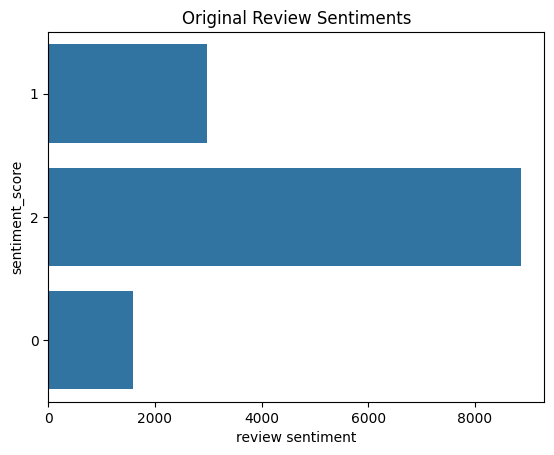

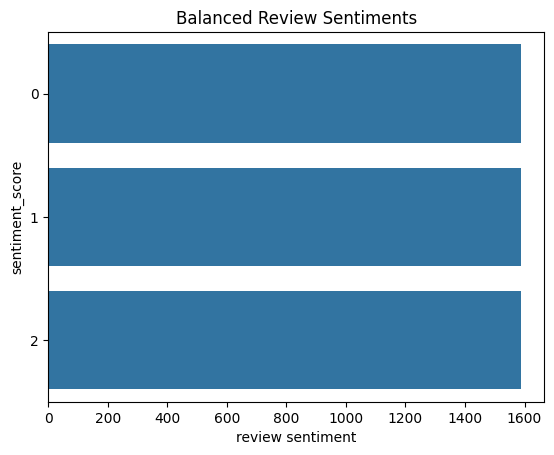

Original dataset size: 13413
Balanced dataset size: 4761


,site,user,review_target,review,score,max_score,norm_score,sentiment_score
0,MyAnimeList,BloodSoakedGoat,Bleach,"Bleach, yea after watching this that's what I ...",3,10,0.3,0
1,MyAnimeList,SmoothJazzDavis,Ergo Proxy,"There is some spoilers into this, there is als...",4,10,0.4,0
2,MyAnimeList,MaudoBomba,Rent-A-Girlfriend,"""Kanojo, Okarishimasu"" is a one-of-a-kind mast...",1,10,0.1,0
3,MyAnimeList,Johan_Liebert_,The Seven Deadly Sins,Garbage anime. The plot was looking good in th...,4,10,0.4,0
4,MyAnimeList,TheTragicPrince,Akame ga Kill!,When I first heard of Akame Ga Kill I was rath...,3,10,0.3,0
...,...,...,...,...,...,...,...,...
4756,MyAnimeList,Kimatea,Barakamon,"Well, my review got deleted for not following ...",9,10,0.9,2
4757,MyAnimeList,Agent_Redacted,Weathering with You,Another beautiful masterpiece created by CoMix...,10,10,1.0,2
4758,MyAnimeList,blushjoy,Hunter x Hunter,I'm not a big shonen follower. I dislike long ...,9,10,0.9,2
4759,MyAnimeList,You,Puella Magi Madoka Magica,"*Might contains minor spoilers, after the revi...",10,10,1.0,2


Loading masked dataset:
    Loading existing dataset file @ myanimelist_masked_data.dt...
Loading reviews dataset:
    Loading existing dataset file @ myanimelist_reviews_data.dt...


In [55]:
reset, pretraining, finetuning = dataset_train_loop("myanimelist")

Masked pretraining:
    train_dataloader: (84 batches)
    test_dataloader: (294 batches)
    valid_dataloader: (42 batches)


{'input_ids': tensor([[  101,  9997,   103,  ...,  2003, 20934,   102],
         [  101,  1045,  2031,  ..., 26316,  1010,   102],
         [  101,  1008,   103,  ...,     0,     0,     0],
         ...,
         [  101,  2023,  2265,  ...,     0,     0,     0],
         [  101,  2092,  1012,  ...,     0,     0,     0],
         [  101,  2065,  1045,  ...,   103,  2393,   102]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'labels': tensor([[  101,  9997, 11867,  ...,  2003, 20934,   102],
         [  101,  1045,  2031,  ..., 26316,  1010,   102],
 

Reviews training:
    train_dataloader: (30 batches)
    test_dataloader: (105 batches)
    valid_dataloader: (15 batches)


{'input_ids': tensor([[  101,  2023,  2265,  ...,     0,     0,     0],
         [  101,  2331,  3602,  ...,     0,     0,     0],
         [  101,  2023,  2265,  ...,  6090,  2818,   102],
         ...,
         [  101,  2061,  1012,  ...,  2027, 13842,   102],
         [  101,  2026,  2061,  ...,  1007,  2036,   102],
         [  101,  8234,  2003,  ...,  4650,  1011,   102]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'original_text': ["This show is all over the place. I wanted so damn bad to love this show, and i still love parts of it, but pa

Training start for 'myanimelist' finetuning...


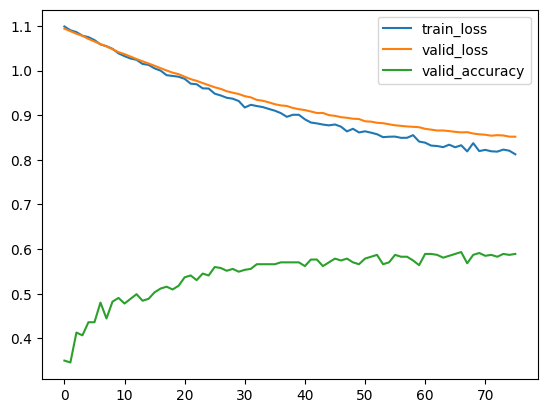

           : 100%|██████████| 15/15 [00:01<00:00, 12.47it/s, loss=1.09, num_correct=tensor(8, device='cuda:0')] 


           : 100%|██████████| 15/15 [00:01<00:00, 12.46it/s, loss=1.06, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 1, 'train_loss': 1.0901812275250753, 'valid_loss': 1.0881728490193685, 'valid_accuracy': 0.34591194968553457}


           : 100%|██████████| 15/15 [00:01<00:00, 12.79it/s, loss=1.09, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 2, 'train_loss': 1.0861071705818177, 'valid_loss': 1.0824326753616333, 'valid_accuracy': 0.4129979035639413}


           : 100%|██████████| 15/15 [00:01<00:00, 13.00it/s, loss=1.07, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 3, 'train_loss': 1.0779401540756226, 'valid_loss': 1.0776556015014649, 'valid_accuracy': 0.40670859538784065}


           : 100%|██████████| 15/15 [00:01<00:00, 12.56it/s, loss=1.1, num_correct=tensor(8, device='cuda:0')]  


           {'epoch': 4, 'train_loss': 1.0747636993726095, 'valid_loss': 1.0708086808522543, 'valid_accuracy': 0.4360587002096436}


           : 100%|██████████| 15/15 [00:01<00:00, 12.48it/s, loss=1.05, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 5, 'train_loss': 1.068187133471171, 'valid_loss': 1.0650938351949055, 'valid_accuracy': 0.4360587002096436}


           : 100%|██████████| 15/15 [00:01<00:00, 12.43it/s, loss=1.06, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 6, 'train_loss': 1.0585313757260641, 'valid_loss': 1.0591966072718302, 'valid_accuracy': 0.480083857442348}


           : 100%|██████████| 15/15 [00:01<00:00, 12.43it/s, loss=1.04, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 7, 'train_loss': 1.0544893066088359, 'valid_loss': 1.0539888779322306, 'valid_accuracy': 0.4444444444444444}


           : 100%|██████████| 15/15 [00:01<00:00, 12.37it/s, loss=1.05, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 8, 'train_loss': 1.0486490845680236, 'valid_loss': 1.0477861166000366, 'valid_accuracy': 0.48218029350104824}


           : 100%|██████████| 15/15 [00:01<00:00, 12.39it/s, loss=1.02, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 9, 'train_loss': 1.0384730736414591, 'valid_loss': 1.0411887725194295, 'valid_accuracy': 0.49056603773584906}


           : 100%|██████████| 15/15 [00:01<00:00, 12.31it/s, loss=0.97, num_correct=tensor(21, device='cuda:0')]


           {'epoch': 10, 'train_loss': 1.032238817214966, 'valid_loss': 1.0367363135019938, 'valid_accuracy': 0.4779874213836478}


           : 100%|██████████| 15/15 [00:01<00:00, 13.02it/s, loss=1.01, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 11, 'train_loss': 1.0268848180770873, 'valid_loss': 1.0312419573465983, 'valid_accuracy': 0.48846960167714887}


           : 100%|██████████| 15/15 [00:01<00:00, 12.03it/s, loss=0.959, num_correct=tensor(20, device='cuda:0')]


           {'epoch': 12, 'train_loss': 1.024036208788554, 'valid_loss': 1.0257635196050008, 'valid_accuracy': 0.4989517819706499}


           : 100%|██████████| 15/15 [00:01<00:00, 12.88it/s, loss=1.01, num_correct=tensor(14, device='cuda:0')] 


           {'epoch': 13, 'train_loss': 1.0147443652153014, 'valid_loss': 1.0206366976102192, 'valid_accuracy': 0.48427672955974843}


           : 100%|██████████| 15/15 [00:01<00:00, 12.57it/s, loss=1.05, num_correct=tensor(10, device='cuda:0')] 


           {'epoch': 14, 'train_loss': 1.012644737958908, 'valid_loss': 1.0157051086425781, 'valid_accuracy': 0.48846960167714887}


           : 100%|██████████| 15/15 [00:01<00:00, 12.88it/s, loss=1.07, num_correct=tensor(10, device='cuda:0')] 


           {'epoch': 15, 'train_loss': 1.004768075545629, 'valid_loss': 1.0106377402941387, 'valid_accuracy': 0.5031446540880503}


           : 100%|██████████| 15/15 [00:01<00:00, 12.92it/s, loss=1, num_correct=tensor(17, device='cuda:0')]    


           {'epoch': 16, 'train_loss': 0.9997605601946513, 'valid_loss': 1.005197858810425, 'valid_accuracy': 0.5115303983228512}


           : 100%|██████████| 15/15 [00:01<00:00, 12.85it/s, loss=1.03, num_correct=tensor(13, device='cuda:0')] 


           {'epoch': 17, 'train_loss': 0.9895210425059001, 'valid_loss': 1.0000961025555928, 'valid_accuracy': 0.5157232704402516}


           : 100%|██████████| 15/15 [00:01<00:00, 12.94it/s, loss=0.966, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 18, 'train_loss': 0.9878636101881663, 'valid_loss': 0.9952253818511962, 'valid_accuracy': 0.5094339622641509}


           : 100%|██████████| 15/15 [00:01<00:00, 12.86it/s, loss=1.01, num_correct=tensor(16, device='cuda:0')] 


           {'epoch': 19, 'train_loss': 0.9860882540543874, 'valid_loss': 0.9918037970860799, 'valid_accuracy': 0.5178197064989518}


           : 100%|██████████| 15/15 [00:01<00:00, 12.93it/s, loss=1.01, num_correct=tensor(17, device='cuda:0')] 


           {'epoch': 20, 'train_loss': 0.9814168552557627, 'valid_loss': 0.9861770391464233, 'valid_accuracy': 0.5366876310272537}


           : 100%|██████████| 15/15 [00:01<00:00, 12.90it/s, loss=0.984, num_correct=tensor(20, device='cuda:0')]


           {'epoch': 21, 'train_loss': 0.9705406645933787, 'valid_loss': 0.9806830406188964, 'valid_accuracy': 0.5408805031446541}


           : 100%|██████████| 15/15 [00:01<00:00, 12.90it/s, loss=0.988, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 22, 'train_loss': 0.9692561248938243, 'valid_loss': 0.9768416086832682, 'valid_accuracy': 0.5303983228511531}


           : 100%|██████████| 15/15 [00:01<00:00, 12.89it/s, loss=0.991, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 23, 'train_loss': 0.960115929444631, 'valid_loss': 0.9719388087590536, 'valid_accuracy': 0.5450733752620545}


           : 100%|██████████| 15/15 [00:01<00:00, 12.92it/s, loss=0.901, num_correct=tensor(20, device='cuda:0')]


           {'epoch': 24, 'train_loss': 0.9596022049585978, 'valid_loss': 0.9671986897786459, 'valid_accuracy': 0.5408805031446541}


           : 100%|██████████| 15/15 [00:01<00:00, 12.42it/s, loss=0.985, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 25, 'train_loss': 0.9481756289800009, 'valid_loss': 0.9624487002690633, 'valid_accuracy': 0.559748427672956}


           : 100%|██████████| 15/15 [00:01<00:00, 11.96it/s, loss=1.07, num_correct=tensor(13, device='cuda:0')] 


           {'epoch': 26, 'train_loss': 0.9441084186236064, 'valid_loss': 0.9589146733283996, 'valid_accuracy': 0.5576519916142557}


           : 100%|██████████| 15/15 [00:01<00:00, 11.80it/s, loss=0.886, num_correct=tensor(21, device='cuda:0')]


           {'epoch': 27, 'train_loss': 0.9389549891153971, 'valid_loss': 0.9535924394925436, 'valid_accuracy': 0.5513626834381551}


           : 100%|██████████| 15/15 [00:01<00:00, 12.47it/s, loss=0.887, num_correct=tensor(19, device='cuda:0')]


           {'epoch': 28, 'train_loss': 0.9368756512800852, 'valid_loss': 0.9503802061080933, 'valid_accuracy': 0.5555555555555556}


           : 100%|██████████| 15/15 [00:01<00:00, 12.74it/s, loss=0.964, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 29, 'train_loss': 0.9316416958967845, 'valid_loss': 0.9473536531130473, 'valid_accuracy': 0.549266247379455}


           : 100%|██████████| 15/15 [00:01<00:00, 12.76it/s, loss=0.876, num_correct=tensor(18, device='cuda:0')]


           {'epoch': 30, 'train_loss': 0.9170991619427998, 'valid_loss': 0.9425819794336955, 'valid_accuracy': 0.5534591194968553}


           : 100%|██████████| 15/15 [00:01<00:00, 12.78it/s, loss=0.901, num_correct=tensor(18, device='cuda:0')]


           {'epoch': 31, 'train_loss': 0.9232211172580719, 'valid_loss': 0.9398839314778645, 'valid_accuracy': 0.5555555555555556}


           : 100%|██████████| 15/15 [00:01<00:00, 12.73it/s, loss=0.869, num_correct=tensor(19, device='cuda:0')]


           {'epoch': 32, 'train_loss': 0.9204252123832702, 'valid_loss': 0.9342249512672425, 'valid_accuracy': 0.5660377358490566}


           : 100%|██████████| 15/15 [00:01<00:00, 12.73it/s, loss=0.907, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 33, 'train_loss': 0.9180884838104248, 'valid_loss': 0.9322777271270752, 'valid_accuracy': 0.5660377358490566}


           : 100%|██████████| 15/15 [00:01<00:00, 12.72it/s, loss=0.896, num_correct=tensor(20, device='cuda:0')]


           {'epoch': 34, 'train_loss': 0.9139706313610076, 'valid_loss': 0.9287135084470113, 'valid_accuracy': 0.5660377358490566}


           : 100%|██████████| 15/15 [00:01<00:00, 12.69it/s, loss=0.891, num_correct=tensor(19, device='cuda:0')]


           {'epoch': 35, 'train_loss': 0.9100183725357056, 'valid_loss': 0.9245305776596069, 'valid_accuracy': 0.5660377358490566}


           : 100%|██████████| 15/15 [00:01<00:00, 12.73it/s, loss=0.797, num_correct=tensor(20, device='cuda:0')]


           {'epoch': 36, 'train_loss': 0.9045808176199596, 'valid_loss': 0.9218406319618225, 'valid_accuracy': 0.570230607966457}


           : 100%|██████████| 15/15 [00:01<00:00, 12.51it/s, loss=0.91, num_correct=tensor(19, device='cuda:0')] 


           {'epoch': 37, 'train_loss': 0.8962573528289794, 'valid_loss': 0.920556918780009, 'valid_accuracy': 0.570230607966457}


           : 100%|██████████| 15/15 [00:01<00:00, 12.83it/s, loss=0.915, num_correct=tensor(18, device='cuda:0')]


           {'epoch': 38, 'train_loss': 0.9008595486481984, 'valid_loss': 0.9160874168078105, 'valid_accuracy': 0.570230607966457}


           : 100%|██████████| 15/15 [00:01<00:00, 12.62it/s, loss=0.891, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 39, 'train_loss': 0.9008590877056122, 'valid_loss': 0.9134507417678833, 'valid_accuracy': 0.570230607966457}


           : 100%|██████████| 15/15 [00:01<00:00, 12.70it/s, loss=0.963, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 40, 'train_loss': 0.8906825900077819, 'valid_loss': 0.9112974087397258, 'valid_accuracy': 0.5618448637316562}


           : 100%|██████████| 15/15 [00:01<00:00, 12.67it/s, loss=0.89, num_correct=tensor(19, device='cuda:0')] 


           {'epoch': 41, 'train_loss': 0.8834908246994019, 'valid_loss': 0.9082641283671061, 'valid_accuracy': 0.5765199161425576}


           : 100%|██████████| 15/15 [00:01<00:00, 12.74it/s, loss=0.912, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 42, 'train_loss': 0.8815237840016683, 'valid_loss': 0.904826557636261, 'valid_accuracy': 0.5765199161425576}


           : 100%|██████████| 15/15 [00:01<00:00, 12.75it/s, loss=0.971, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 43, 'train_loss': 0.8789368510246277, 'valid_loss': 0.9049063245455424, 'valid_accuracy': 0.5618448637316562}


           : 100%|██████████| 15/15 [00:01<00:00, 12.47it/s, loss=0.841, num_correct=tensor(19, device='cuda:0')]


           {'epoch': 44, 'train_loss': 0.8771333316961925, 'valid_loss': 0.9000422159830729, 'valid_accuracy': 0.570230607966457}


           : 100%|██████████| 15/15 [00:01<00:00, 12.50it/s, loss=0.922, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 45, 'train_loss': 0.8791120151678721, 'valid_loss': 0.8985060056050619, 'valid_accuracy': 0.5786163522012578}


           : 100%|██████████| 15/15 [00:01<00:00, 12.51it/s, loss=0.939, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 46, 'train_loss': 0.874242776632309, 'valid_loss': 0.895501172542572, 'valid_accuracy': 0.5744234800838575}


           : 100%|██████████| 15/15 [00:01<00:00, 12.33it/s, loss=0.922, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 47, 'train_loss': 0.8636296093463898, 'valid_loss': 0.8940799276034037, 'valid_accuracy': 0.5786163522012578}


           : 100%|██████████| 15/15 [00:01<00:00, 12.93it/s, loss=0.962, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 48, 'train_loss': 0.8694829086462657, 'valid_loss': 0.8919807434082031, 'valid_accuracy': 0.570230607966457}


           : 100%|██████████| 15/15 [00:01<00:00, 12.41it/s, loss=0.941, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 49, 'train_loss': 0.8612055639425914, 'valid_loss': 0.8913978139559428, 'valid_accuracy': 0.5660377358490566}


           : 100%|██████████| 15/15 [00:01<00:00, 12.84it/s, loss=0.869, num_correct=tensor(22, device='cuda:0')]


           {'epoch': 50, 'train_loss': 0.8638469735781352, 'valid_loss': 0.8862821499506632, 'valid_accuracy': 0.5786163522012578}


           : 100%|██████████| 15/15 [00:01<00:00, 12.88it/s, loss=0.991, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 51, 'train_loss': 0.8607621947924297, 'valid_loss': 0.8854931354522705, 'valid_accuracy': 0.5828092243186582}


           : 100%|██████████| 15/15 [00:01<00:00, 12.86it/s, loss=0.866, num_correct=tensor(21, device='cuda:0')]


           {'epoch': 52, 'train_loss': 0.8572778582572937, 'valid_loss': 0.8829321146011353, 'valid_accuracy': 0.5870020964360587}


           : 100%|██████████| 15/15 [00:01<00:00, 12.49it/s, loss=0.782, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 53, 'train_loss': 0.8506937901178996, 'valid_loss': 0.8820249795913696, 'valid_accuracy': 0.5660377358490566}


           : 100%|██████████| 15/15 [00:01<00:00, 12.74it/s, loss=0.817, num_correct=tensor(20, device='cuda:0')]


           {'epoch': 54, 'train_loss': 0.8516892651716869, 'valid_loss': 0.8795024911562602, 'valid_accuracy': 0.570230607966457}


           : 100%|██████████| 15/15 [00:01<00:00, 13.00it/s, loss=0.861, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 55, 'train_loss': 0.8519759098688762, 'valid_loss': 0.8773101528485616, 'valid_accuracy': 0.5870020964360587}


           : 100%|██████████| 15/15 [00:01<00:00, 13.02it/s, loss=0.891, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 56, 'train_loss': 0.8491448819637298, 'valid_loss': 0.8759920756022136, 'valid_accuracy': 0.5828092243186582}


           : 100%|██████████| 15/15 [00:01<00:00, 12.70it/s, loss=0.827, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 57, 'train_loss': 0.8493035038312277, 'valid_loss': 0.8746526519457499, 'valid_accuracy': 0.5828092243186582}


           : 100%|██████████| 15/15 [00:01<00:00, 12.71it/s, loss=0.908, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 58, 'train_loss': 0.8552150348822276, 'valid_loss': 0.8738930821418762, 'valid_accuracy': 0.5744234800838575}


           : 100%|██████████| 15/15 [00:01<00:00, 11.41it/s, loss=0.914, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 59, 'train_loss': 0.8408134341239929, 'valid_loss': 0.8729705572128296, 'valid_accuracy': 0.5639412997903563}


           : 100%|██████████| 15/15 [00:01<00:00, 13.01it/s, loss=0.818, num_correct=tensor(19, device='cuda:0')]


           {'epoch': 60, 'train_loss': 0.8383744974931081, 'valid_loss': 0.8694145878156027, 'valid_accuracy': 0.589098532494759}


           : 100%|██████████| 15/15 [00:01<00:00, 12.75it/s, loss=0.901, num_correct=tensor(18, device='cuda:0')]


           {'epoch': 61, 'train_loss': 0.8318146049976349, 'valid_loss': 0.8675375501314799, 'valid_accuracy': 0.589098532494759}


           : 100%|██████████| 15/15 [00:01<00:00, 13.07it/s, loss=0.811, num_correct=tensor(19, device='cuda:0')]


           {'epoch': 62, 'train_loss': 0.8308472116788228, 'valid_loss': 0.8655851046244304, 'valid_accuracy': 0.5870020964360587}


           : 100%|██████████| 15/15 [00:01<00:00, 12.09it/s, loss=0.917, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 63, 'train_loss': 0.8283579568068187, 'valid_loss': 0.8656713724136352, 'valid_accuracy': 0.5807127882599581}


           : 100%|██████████| 15/15 [00:01<00:00, 12.81it/s, loss=0.807, num_correct=tensor(20, device='cuda:0')]


           {'epoch': 64, 'train_loss': 0.8338000297546386, 'valid_loss': 0.8643023570378622, 'valid_accuracy': 0.5849056603773585}


           : 100%|██████████| 15/15 [00:01<00:00, 12.92it/s, loss=0.849, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 65, 'train_loss': 0.8281264841556549, 'valid_loss': 0.8626279473304749, 'valid_accuracy': 0.589098532494759}


           : 100%|██████████| 15/15 [00:01<00:00, 13.04it/s, loss=0.888, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 66, 'train_loss': 0.8325392067432403, 'valid_loss': 0.861347758769989, 'valid_accuracy': 0.5932914046121593}


           : 100%|██████████| 15/15 [00:01<00:00, 12.46it/s, loss=0.815, num_correct=tensor(19, device='cuda:0')]


           {'epoch': 67, 'train_loss': 0.8187802056471507, 'valid_loss': 0.8618941028912862, 'valid_accuracy': 0.5681341719077568}


           : 100%|██████████| 15/15 [00:01<00:00, 12.91it/s, loss=0.888, num_correct=tensor(20, device='cuda:0')]


           {'epoch': 68, 'train_loss': 0.8373059074083964, 'valid_loss': 0.8588398178418477, 'valid_accuracy': 0.5870020964360587}


           : 100%|██████████| 15/15 [00:01<00:00, 12.92it/s, loss=0.879, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 69, 'train_loss': 0.8195470690727233, 'valid_loss': 0.8570653915405273, 'valid_accuracy': 0.5911949685534591}


           : 100%|██████████| 15/15 [00:01<00:00, 12.95it/s, loss=0.869, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 70, 'train_loss': 0.8222116351127624, 'valid_loss': 0.8561713178952535, 'valid_accuracy': 0.5849056603773585}


           : 100%|██████████| 15/15 [00:01<00:00, 12.88it/s, loss=0.818, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 71, 'train_loss': 0.8190578202406565, 'valid_loss': 0.8539805889129639, 'valid_accuracy': 0.5870020964360587}


           : 100%|██████████| 15/15 [00:01<00:00, 12.35it/s, loss=0.923, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 72, 'train_loss': 0.8182954808076223, 'valid_loss': 0.8551798184712728, 'valid_accuracy': 0.5828092243186582}


           : 100%|██████████| 15/15 [00:01<00:00, 12.55it/s, loss=1.09, num_correct=tensor(11, device='cuda:0')] 


           {'epoch': 73, 'train_loss': 0.8228404462337494, 'valid_loss': 0.8545013268788656, 'valid_accuracy': 0.589098532494759}


           : 100%|██████████| 15/15 [00:01<00:00, 12.96it/s, loss=0.761, num_correct=tensor(19, device='cuda:0')]


           {'epoch': 74, 'train_loss': 0.820375535885493, 'valid_loss': 0.8519031922022502, 'valid_accuracy': 0.5870020964360587}


           : 100%|██████████| 15/15 [00:01<00:00, 12.75it/s, loss=0.902, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 75, 'train_loss': 0.8123653451601665, 'valid_loss': 0.851722792784373, 'valid_accuracy': 0.589098532494759}
Stopping early...


In [56]:
reset(train_bert_in_finetune=False)
pretraining(pretrained_model_name="distilbert/distilbert-base-uncased")
finetuning(stop_delta_loss=0.005)

## Steam

Training BERT on Steam only.

Loaded training config:


{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'pretrained_model_name': '', 'name': 'steam', 'class_names': ['negative', 'neutral', 'positive'], 'stop_delta':

Loaded steam:


,site,user,review_target,review,score,max_score
0,steam,Spool Lyger,Schedule I,Amazing game. Easily 30-40 hours of game play....,1,1
1,steam,Hungry.Hungry.Hobo,Schedule I,"For a just ""released in early access game"" the...",1,1
2,steam,Shambalili,Schedule I,day time comes: pickpocket the whole city nigh...,1,1
3,steam,Auldben,Schedule I,Made a type of weed that the game called Tokyo...,1,1
4,steam,ctolsen,Schedule I,"A woman came up to me and asked for weed, didn...",1,1
...,...,...,...,...,...,...
21360,steam,YourlocalHobbo,Ghost of Tsushima DIRECTOR'S CUT,"Absolutely breathtaking story, felt connected ...",1,1
21361,steam,Wallace,Ghost of Tsushima DIRECTOR'S CUT,"peak game, like this is all you could ask for ...",1,1
21362,steam,Yume,Ghost of Tsushima DIRECTOR'S CUT,It's one of the best modern story-driven actio...,1,1
21363,steam,Star,Ghost of Tsushima DIRECTOR'S CUT,I have now reached 100 hours on this game and ...,1,1


C:\Users\Alan\AppData\Local\Temp\ipykernel_1148\2008806600.py:457: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = g.apply(lambda x: x.sample(min_group_size)).reset_index(drop=True)


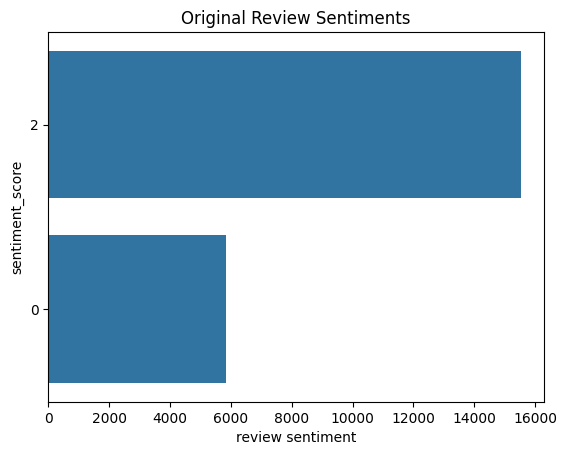

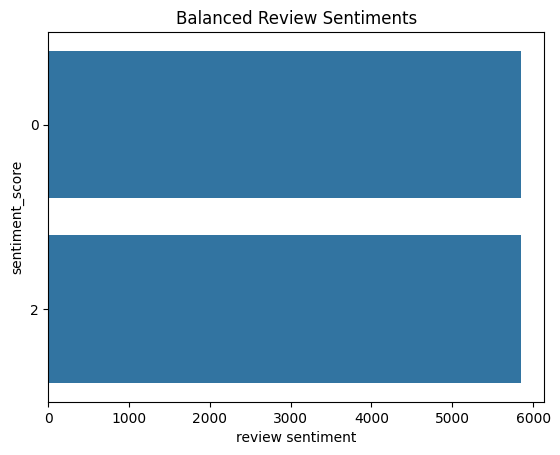

Original dataset size: 21365
Balanced dataset size: 11688


,site,user,review_target,review,score,max_score,norm_score,sentiment_score
0,steam,Schapie,Sid Meier's Civilization VII,"Its half a game, even more so than previous en...",0,1,0.0,0
1,steam,panzerlehr4,Arma Reforger,Probably a fun Mil Sim but with 3 hrs in and 9...,0,1,0.0,0
2,steam,Alex,No More Room in Hell 2,"LOL Such unfinished game, not even close to Al...",0,1,0.0,0
3,steam,🅱️otato,HELLDIVERS™ 2,You dont need a PSN account anymore to play th...,0,1,0.0,0
4,steam,Differ,inZOI,"For now inZOI fails at what is meant to be, a ...",0,1,0.0,0
...,...,...,...,...,...,...,...,...
11683,steam,☯Misutāyagi☯,Palworld,game consist mostly of slavery and playing wit...,1,1,1.0,2
11684,steam,RandomSquad,R.E.P.O.,7.2 hours of playing the game... I've been the...,1,1,1.0,2
11685,steam,Zoomy Goomy,RuneScape: Dragonwilds,I think it's a brilliant start to something th...,1,1,1.0,2
11686,steam,ZveR1k™,STAR WARS™: The Old Republic™,"I've been playing this ""MMO"" (though it's more...",1,1,1.0,2


Loading masked dataset:
    Loading existing dataset file @ steam_masked_data.dt...
Loading reviews dataset:
    Loading existing dataset file @ steam_reviews_data.dt...


In [42]:
reset, pretraining, finetuning = dataset_train_loop("steam")

Masked pretraining:
    train_dataloader: (134 batches)
    test_dataloader: (468 batches)
    valid_dataloader: (67 batches)


{'input_ids': tensor([[  101, 17950,  6579,  ...,     0,     0,     0],
         [  101, 12882,  3179,  ...,     0,     0,     0],
         [  101,   103,   103,  ...,     0,     0,     0],
         ...,
         [  101,  1996,  4684,  ...,     0,     0,     0],
         [  101,  2065,  2017,  ...,     0,     0,     0],
         [  101,  2130,  2007,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([[  101, 17950,  6579,  ...,     0,     0,     0],
         [  101, 12882,  3179,  ...,     0,     0,     0],
         [  101,  2377,  6359,  ...,     0,     0,     0],
         ...,
         [  101,  1996,  4684,  ...,     0,     0,     0],
         [  101,  2065,  2017,  ...,     0,     0,     0],
         [  101,  2130,  2007,  ...,     0,     0,    

Reviews training:
    train_dataloader: (74 batches)
    test_dataloader: (256 batches)
    valid_dataloader: (37 batches)


{'input_ids': tensor([[  101,  2359,  2000,  ...,  2013, 19413,   102],
         [  101,  3404,  2053,  ...,     0,     0,     0],
         [  101,  9882,  2396,  ...,     0,     0,     0],
         ...,
         [  101,  2034,  1997,  ...,     0,     0,     0],
         [  101,  2023,  2208,  ...,     0,     0,     0],
         [  101,  2065,  2017,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'original_text': ['Wanted to wait until 1000 hours to write anything, though admittedly I knew for the last ~500 where this was going to end up. I LOVE this game at its core. The actual game loop, the gamePLAY - wonderful stuff. Would literally never get old IF the matchmaking were...different(?) Stop me if you\'ve heard this one before... To preface this, I want to add

Training start for 'steam' finetuning...


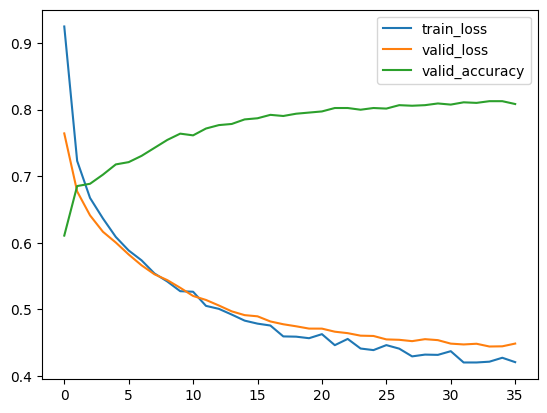

           : 100%|██████████| 37/37 [00:02<00:00, 12.57it/s, loss=0.779, num_correct=tensor(10, device='cuda:0')]


           : 100%|██████████| 37/37 [00:02<00:00, 12.51it/s, loss=0.687, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 1, 'train_loss': 0.7229560275335569, 'valid_loss': 0.6771689234553157, 'valid_accuracy': 0.6852010265183918}


           : 100%|██████████| 37/37 [00:02<00:00, 12.83it/s, loss=0.595, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 2, 'train_loss': 0.6673431251500104, 'valid_loss': 0.6411809260780746, 'valid_accuracy': 0.688622754491018}


           : 100%|██████████| 37/37 [00:02<00:00, 12.97it/s, loss=0.642, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 3, 'train_loss': 0.6365922045063328, 'valid_loss': 0.6165687989544224, 'valid_accuracy': 0.7023096663815227}


           : 100%|██████████| 37/37 [00:02<00:00, 12.43it/s, loss=0.638, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 4, 'train_loss': 0.6087604736959612, 'valid_loss': 0.6004063100428194, 'valid_accuracy': 0.7177074422583405}


           : 100%|██████████| 37/37 [00:02<00:00, 13.02it/s, loss=0.641, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 5, 'train_loss': 0.5884440629868894, 'valid_loss': 0.5824187994003296, 'valid_accuracy': 0.7211291702309667}


           : 100%|██████████| 37/37 [00:02<00:00, 12.97it/s, loss=0.611, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 6, 'train_loss': 0.5736459352680154, 'valid_loss': 0.5661602406888395, 'valid_accuracy': 0.7305389221556886}


           : 100%|██████████| 37/37 [00:02<00:00, 12.90it/s, loss=0.507, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 7, 'train_loss': 0.5539616531616932, 'valid_loss': 0.5527161110091854, 'valid_accuracy': 0.7425149700598802}


           : 100%|██████████| 37/37 [00:02<00:00, 12.62it/s, loss=0.58, num_correct=tensor(12, device='cuda:0')] 


           {'epoch': 8, 'train_loss': 0.5418261039901424, 'valid_loss': 0.5439184606075287, 'valid_accuracy': 0.7544910179640718}


           : 100%|██████████| 37/37 [00:02<00:00, 12.98it/s, loss=0.462, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 9, 'train_loss': 0.5273080995759448, 'valid_loss': 0.5324319858808775, 'valid_accuracy': 0.7639007698887939}


           : 100%|██████████| 37/37 [00:02<00:00, 12.99it/s, loss=0.47, num_correct=tensor(15, device='cuda:0')] 


           {'epoch': 10, 'train_loss': 0.5264825128220223, 'valid_loss': 0.5201441645622253, 'valid_accuracy': 0.7613344739093242}


           : 100%|██████████| 37/37 [00:02<00:00, 12.85it/s, loss=0.435, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 11, 'train_loss': 0.5052669710806899, 'valid_loss': 0.5141594643528397, 'valid_accuracy': 0.7715996578272027}


           : 100%|██████████| 37/37 [00:02<00:00, 12.91it/s, loss=0.579, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 12, 'train_loss': 0.5007856105630463, 'valid_loss': 0.505825853025591, 'valid_accuracy': 0.776732249786142}


           : 100%|██████████| 37/37 [00:02<00:00, 12.96it/s, loss=0.406, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 13, 'train_loss': 0.4921769399095226, 'valid_loss': 0.4970184532371727, 'valid_accuracy': 0.7784431137724551}


           : 100%|██████████| 37/37 [00:02<00:00, 12.77it/s, loss=0.341, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 14, 'train_loss': 0.4831055169169967, 'valid_loss': 0.49135961725905136, 'valid_accuracy': 0.7852865697177075}


           : 100%|██████████| 37/37 [00:02<00:00, 13.02it/s, loss=0.612, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 15, 'train_loss': 0.4785828916607676, 'valid_loss': 0.489574806110279, 'valid_accuracy': 0.7869974337040205}


           : 100%|██████████| 37/37 [00:02<00:00, 12.35it/s, loss=0.441, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 16, 'train_loss': 0.47574920791226466, 'valid_loss': 0.48185289228284683, 'valid_accuracy': 0.7921300256629598}


           : 100%|██████████| 37/37 [00:02<00:00, 12.89it/s, loss=0.395, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 17, 'train_loss': 0.4594018151228492, 'valid_loss': 0.4776586036424379, 'valid_accuracy': 0.7904191616766467}


           : 100%|██████████| 37/37 [00:02<00:00, 12.96it/s, loss=0.486, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 18, 'train_loss': 0.4590136775293866, 'valid_loss': 0.4745819109517175, 'valid_accuracy': 0.7938408896492729}


           : 100%|██████████| 37/37 [00:02<00:00, 12.93it/s, loss=0.373, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 19, 'train_loss': 0.4566989755509673, 'valid_loss': 0.47113374278352066, 'valid_accuracy': 0.795551753635586}


           : 100%|██████████| 37/37 [00:02<00:00, 12.96it/s, loss=0.647, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 20, 'train_loss': 0.46278482836646, 'valid_loss': 0.47109589222315196, 'valid_accuracy': 0.7972626176218991}


           : 100%|██████████| 37/37 [00:02<00:00, 12.93it/s, loss=0.507, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 21, 'train_loss': 0.44623561143069657, 'valid_loss': 0.4664822953778344, 'valid_accuracy': 0.8023952095808383}


           : 100%|██████████| 37/37 [00:02<00:00, 12.93it/s, loss=0.606, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 22, 'train_loss': 0.45562687838399735, 'valid_loss': 0.46429071394172877, 'valid_accuracy': 0.8023952095808383}


           : 100%|██████████| 37/37 [00:02<00:00, 12.49it/s, loss=0.484, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 23, 'train_loss': 0.4412046954841227, 'valid_loss': 0.4605206557222315, 'valid_accuracy': 0.7998289136013687}


           : 100%|██████████| 37/37 [00:02<00:00, 12.89it/s, loss=0.474, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 24, 'train_loss': 0.43883323669433594, 'valid_loss': 0.4600667977655256, 'valid_accuracy': 0.8023952095808383}


           : 100%|██████████| 37/37 [00:02<00:00, 12.93it/s, loss=0.343, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 25, 'train_loss': 0.446323401219136, 'valid_loss': 0.45490683252746994, 'valid_accuracy': 0.8015397775876818}


           : 100%|██████████| 37/37 [00:02<00:00, 13.02it/s, loss=0.447, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 26, 'train_loss': 0.44101647307743896, 'valid_loss': 0.45429875319068497, 'valid_accuracy': 0.806672369546621}


           : 100%|██████████| 37/37 [00:02<00:00, 12.94it/s, loss=0.354, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 27, 'train_loss': 0.4294011672404972, 'valid_loss': 0.4522914016568983, 'valid_accuracy': 0.8058169375534645}


           : 100%|██████████| 37/37 [00:02<00:00, 12.96it/s, loss=0.445, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 28, 'train_loss': 0.43207708625374613, 'valid_loss': 0.4552582260724661, 'valid_accuracy': 0.806672369546621}


           : 100%|██████████| 37/37 [00:03<00:00, 12.21it/s, loss=0.611, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 29, 'train_loss': 0.43166640118972677, 'valid_loss': 0.4538020121084677, 'valid_accuracy': 0.8092386655260907}


           : 100%|██████████| 37/37 [00:02<00:00, 12.98it/s, loss=0.409, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 30, 'train_loss': 0.4372070089385316, 'valid_loss': 0.448557090920371, 'valid_accuracy': 0.8075278015397775}


           : 100%|██████████| 37/37 [00:02<00:00, 12.88it/s, loss=0.309, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 31, 'train_loss': 0.42025229918795665, 'valid_loss': 0.447332305682672, 'valid_accuracy': 0.8109495295124037}


           : 100%|██████████| 37/37 [00:02<00:00, 12.73it/s, loss=0.402, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 32, 'train_loss': 0.42025780476428365, 'valid_loss': 0.4483722649716042, 'valid_accuracy': 0.8100940975192472}


           : 100%|██████████| 37/37 [00:02<00:00, 12.80it/s, loss=0.328, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 33, 'train_loss': 0.42144338061680664, 'valid_loss': 0.4442397444634824, 'valid_accuracy': 0.8126603934987169}


           : 100%|██████████| 37/37 [00:02<00:00, 12.72it/s, loss=0.427, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 34, 'train_loss': 0.4273332893042951, 'valid_loss': 0.4445200236262502, 'valid_accuracy': 0.8126603934987169}


           : 100%|██████████| 37/37 [00:02<00:00, 12.99it/s, loss=0.588, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 35, 'train_loss': 0.42075701259277964, 'valid_loss': 0.4486410883632866, 'valid_accuracy': 0.8083832335329342}
Stopping early...


In [43]:
reset(train_bert_in_finetune=False)
pretraining(pretrained_model_name="distilbert/distilbert-base-uncased")
finetuning(stop_delta_loss=0.005)

## Metacritic

Training BERT on Metacritic only.

Loaded training config:


{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'pretrained_model_name': '', 'name': 'metacritic', 'class_names': ['negative', 'neutral', 'positive'], 'stop_de

Loaded metacritic:


,site,user,review_target,review,score,max_score
0,metacritic,ArcherOfSwabia,minecraft,Boring game that was soulless even in the begi...,0,10
1,metacritic,sheonaner,minecraft,"the best, the only, the unique game in its gen...",10,10
2,metacritic,AverageJoe809,minecraft,Not my cup of tea due to so many choices. Stil...,9,10
3,metacritic,GUILHERMNZ7,minecraft,Film He was Very average More I gave Credit By...,8,10
4,metacritic,Jogaron,minecraft,"Minecraft é muito criativo, dá muita liberdade...",7,10
...,...,...,...,...,...,...
8576,metacritic,mculy27,helldivers-2,For democracy! Great game with some flaws. But...,10,10
8577,metacritic,Scorpionking144,helldivers-2,"The game started out as a good challenge, and ...",2,10
8578,metacritic,adamtheclark,helldivers-2,People seem to forget that Arrowhead did not k...,9,10
8579,metacritic,PS,helldivers-2,Beat it 100% i like it a lot we need Venicles...,10,10


C:\Users\Alan\AppData\Local\Temp\ipykernel_1148\2008806600.py:457: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = g.apply(lambda x: x.sample(min_group_size)).reset_index(drop=True)


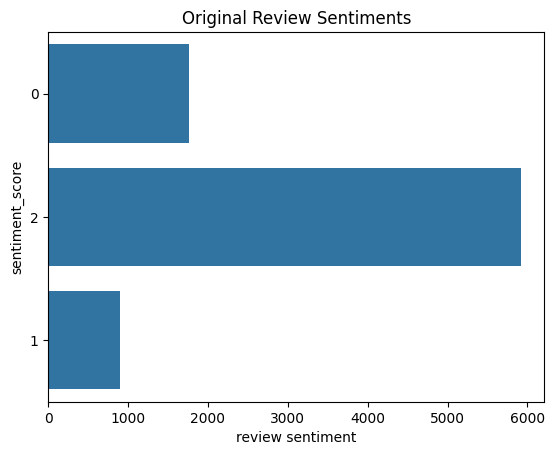

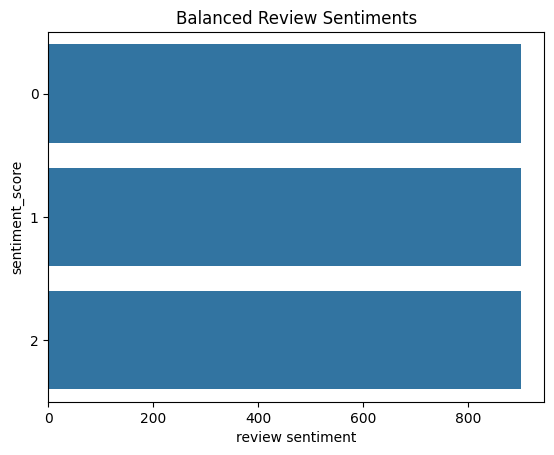

Original dataset size: 8581
Balanced dataset size: 2703


,site,user,review_target,review,score,max_score,norm_score,sentiment_score
0,metacritic,bootyfarm,terraria,"Color scheme is all weird, controls are clunky...",2,10,0.2,0
1,metacritic,LeGif,war-thunder,The company has made this game unplayable. The...,0,10,0.0,0
2,metacritic,Turbo1,super-meat-boy,i have never in my life played a platformer wh...,2,10,0.2,0
3,metacritic,sfgdfhfn,overwatch-2,copy paste game no pve with skill tree p2w bat...,0,10,0.0,0
4,metacritic,pogimabus,fez,Very esoteric puzzler... maybe I came looking ...,3,10,0.3,0
...,...,...,...,...,...,...,...,...
2698,metacritic,vinidr,minecraft,versão java: 10/10\nbedrock: 9/10 \n\n‎‎‎‎‎‎‎‎...,10,10,1.0,2
2699,metacritic,thecasualgaymer,a-short-hike,A personal favorite of mine and a perfect exam...,9,10,0.9,2
2700,metacritic,Eduard0X,enter-the-gungeon,Un juego que igual que el jugo Isaac está bien...,9,10,0.9,2
2701,metacritic,FREEPALESTINE,hotline-miami,[SPOILER ALERT: This review contains spoilers.],7,10,0.7,2


Loading masked dataset:
    Loading existing dataset file @ metacritic_masked_data.dt...
Loading reviews dataset:
    Loading existing dataset file @ metacritic_reviews_data.dt...


In [44]:
reset, pretraining, finetuning = dataset_train_loop("metacritic")

Masked pretraining:
    train_dataloader: (54 batches)
    test_dataloader: (188 batches)
    valid_dataloader: (27 batches)


{'input_ids': tensor([[ 101, 2023,  103,  ...,    0,    0,    0],
         [ 101,  103, 2123,  ...,    0,    0,    0],
         [ 101, 2065, 2017,  ...,    0,    0,    0],
         ...,
         [ 101, 2763,  103,  ...,    0,    0,    0],
         [ 101, 5292, 2099,  ...,    0,    0,    0],
         [ 101, 2009, 1005,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([[ 101, 2023, 2208,  ...,    0,    0,    0],
         [ 101, 1045, 2123,  ...,    0,    0,    0],
         [ 101, 2065, 2017,  ...,    0,    0,    0],
         ...,
         [ 101, 2763, 1996,  ...,    0,    0,    0],
         [ 101, 5292, 2099,  ...,    0,    0,    0],
         [ 101, 2009, 1005,  ...,    0,    0,    0]]),
 'original_text': ['This game is a showcase of how Ubisoft can ma

Reviews training:
    train_dataloader: (17 batches)
    test_dataloader: (60 batches)
    valid_dataloader: (9 batches)


{'input_ids': tensor([[  101,  2428,  6659,  ...,     0,     0,     0],
         [  101,  3481,  3490,  ...,     0,     0,     0],
         [  101,  2208, 18699,  ...,     0,     0,     0],
         ...,
         [  101,  6057, 17674,  ...,     0,     0,     0],
         [  101,  2004,  2619,  ...,     0,     0,     0],
         [  101,  1189, 16856,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'original_text': ["Really terrible customer service, some of the worst support i've ever experienced... Really compounds some of the insanely greedy monetization that has turned the game into a lootbox simulator. Save yourself the time, the headache and your wallet and give this one a miss.",
  "Fortnite used to be great, yet now it is a cringe, boring, heartless game f

Training start for 'metacritic' finetuning...


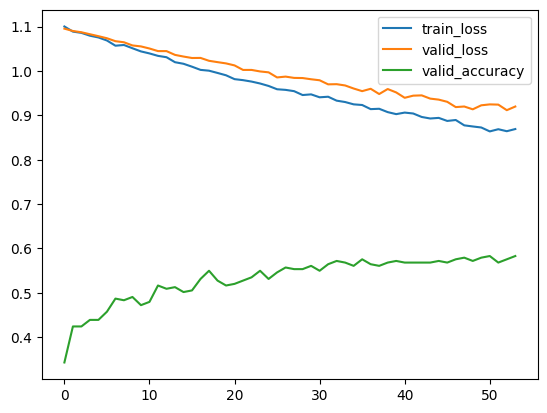

           : 100%|██████████| 9/9 [00:00<00:00, 12.61it/s, loss=1.08, num_correct=tensor(6, device='cuda:0')] 


           : 100%|██████████| 9/9 [00:00<00:00, 13.53it/s, loss=1.09, num_correct=tensor(4, device='cuda:0')] 


           {'epoch': 1, 'train_loss': 1.0886671192505781, 'valid_loss': 1.0900751484764948, 'valid_accuracy': 0.42435424354243545}


           : 100%|██████████| 9/9 [00:00<00:00, 13.60it/s, loss=1.09, num_correct=tensor(4, device='cuda:0')] 


           {'epoch': 2, 'train_loss': 1.0858486820669735, 'valid_loss': 1.0872221257951524, 'valid_accuracy': 0.42435424354243545}


           : 100%|██████████| 9/9 [00:00<00:00, 13.51it/s, loss=1.1, num_correct=tensor(4, device='cuda:0')]  


           {'epoch': 3, 'train_loss': 1.0794398924883675, 'valid_loss': 1.082779884338379, 'valid_accuracy': 0.43911439114391143}


           : 100%|██████████| 9/9 [00:00<00:00, 13.47it/s, loss=1.09, num_correct=tensor(4, device='cuda:0')] 


           {'epoch': 4, 'train_loss': 1.0755040224860697, 'valid_loss': 1.0783736970689561, 'valid_accuracy': 0.43911439114391143}


           : 100%|██████████| 9/9 [00:00<00:00, 13.51it/s, loss=1.09, num_correct=tensor(7, device='cuda:0')] 


           {'epoch': 5, 'train_loss': 1.0686445656944723, 'valid_loss': 1.073730813132392, 'valid_accuracy': 0.4575645756457565}


           : 100%|██████████| 9/9 [00:00<00:00, 13.64it/s, loss=1.05, num_correct=tensor(8, device='cuda:0')] 


           {'epoch': 6, 'train_loss': 1.0569183125215418, 'valid_loss': 1.0670965380138822, 'valid_accuracy': 0.4870848708487085}


           : 100%|██████████| 9/9 [00:00<00:00, 13.64it/s, loss=1.08, num_correct=tensor(5, device='cuda:0')] 


           {'epoch': 7, 'train_loss': 1.0585264738868265, 'valid_loss': 1.0646622975667317, 'valid_accuracy': 0.4833948339483395}


           : 100%|██████████| 9/9 [00:00<00:00, 13.57it/s, loss=1.03, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 8, 'train_loss': 1.0511732381932877, 'valid_loss': 1.0575181643168132, 'valid_accuracy': 0.4907749077490775}


           : 100%|██████████| 9/9 [00:00<00:00, 13.45it/s, loss=1.04, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 9, 'train_loss': 1.0440561911639046, 'valid_loss': 1.0553138785892062, 'valid_accuracy': 0.47232472324723246}


           : 100%|██████████| 9/9 [00:00<00:00, 13.53it/s, loss=1.03, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 10, 'train_loss': 1.0395215048509485, 'valid_loss': 1.0506050851609972, 'valid_accuracy': 0.4797047970479705}


           : 100%|██████████| 9/9 [00:00<00:00, 13.60it/s, loss=1.02, num_correct=tensor(8, device='cuda:0')] 


           {'epoch': 11, 'train_loss': 1.0340359842076021, 'valid_loss': 1.0447844399346247, 'valid_accuracy': 0.5166051660516605}


           : 100%|██████████| 9/9 [00:00<00:00, 13.68it/s, loss=1.08, num_correct=tensor(6, device='cuda:0')] 


           {'epoch': 12, 'train_loss': 1.0309712466071634, 'valid_loss': 1.0447398689058092, 'valid_accuracy': 0.5092250922509225}


           : 100%|██████████| 9/9 [00:00<00:00, 13.68it/s, loss=1, num_correct=tensor(7, device='cuda:0')]    


           {'epoch': 13, 'train_loss': 1.0197358762516695, 'valid_loss': 1.036230934990777, 'valid_accuracy': 0.5129151291512916}


           : 100%|██████████| 9/9 [00:00<00:00, 13.62it/s, loss=1, num_correct=tensor(8, device='cuda:0')]    


           {'epoch': 14, 'train_loss': 1.0161976183162016, 'valid_loss': 1.0324876838260226, 'valid_accuracy': 0.5018450184501845}


           : 100%|██████████| 9/9 [00:00<00:00, 13.51it/s, loss=1, num_correct=tensor(9, device='cuda:0')]     


           {'epoch': 15, 'train_loss': 1.0096215290181778, 'valid_loss': 1.0292087131076388, 'valid_accuracy': 0.5055350553505535}


           : 100%|██████████| 9/9 [00:00<00:00, 13.29it/s, loss=1.1, num_correct=tensor(5, device='cuda:0')]   


           {'epoch': 16, 'train_loss': 1.0024580324397367, 'valid_loss': 1.029389758904775, 'valid_accuracy': 0.5313653136531366}


           : 100%|██████████| 9/9 [00:00<00:00, 13.74it/s, loss=1.05, num_correct=tensor(8, device='cuda:0')]  


           {'epoch': 17, 'train_loss': 1.0006248495158028, 'valid_loss': 1.0229045550028484, 'valid_accuracy': 0.5498154981549815}


           : 100%|██████████| 9/9 [00:00<00:00, 13.68it/s, loss=1.05, num_correct=tensor(8, device='cuda:0')]  


           {'epoch': 18, 'train_loss': 0.9955362782758825, 'valid_loss': 1.019895977444119, 'valid_accuracy': 0.5276752767527675}


           : 100%|██████████| 9/9 [00:00<00:00, 13.59it/s, loss=1.05, num_correct=tensor(6, device='cuda:0')]  


           {'epoch': 19, 'train_loss': 0.990257508614484, 'valid_loss': 1.0170464780595567, 'valid_accuracy': 0.5166051660516605}


           : 100%|██████████| 9/9 [00:00<00:00, 13.74it/s, loss=1.04, num_correct=tensor(6, device='cuda:0')]  


           {'epoch': 20, 'train_loss': 0.9815678876989028, 'valid_loss': 1.0125161939197116, 'valid_accuracy': 0.5202952029520295}


           : 100%|██████████| 9/9 [00:00<00:00, 13.70it/s, loss=0.934, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 21, 'train_loss': 0.9793049868415383, 'valid_loss': 1.0023339920573764, 'valid_accuracy': 0.5276752767527675}


           : 100%|██████████| 9/9 [00:00<00:00, 13.53it/s, loss=1, num_correct=tensor(7, device='cuda:0')]     


           {'epoch': 22, 'train_loss': 0.9760841376641217, 'valid_loss': 1.0023390187157526, 'valid_accuracy': 0.5350553505535055}


           : 100%|██████████| 9/9 [00:00<00:00, 13.57it/s, loss=1.01, num_correct=tensor(7, device='cuda:0')]  


           {'epoch': 23, 'train_loss': 0.9717751811532414, 'valid_loss': 0.9989290899700589, 'valid_accuracy': 0.5498154981549815}


           : 100%|██████████| 9/9 [00:00<00:00, 13.17it/s, loss=1.01, num_correct=tensor(8, device='cuda:0')]  


           {'epoch': 24, 'train_loss': 0.9662427446421455, 'valid_loss': 0.9968988166915046, 'valid_accuracy': 0.5313653136531366}


           : 100%|██████████| 9/9 [00:00<00:00, 13.06it/s, loss=0.888, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 25, 'train_loss': 0.958786708467147, 'valid_loss': 0.9854465789265103, 'valid_accuracy': 0.5461254612546126}


           : 100%|██████████| 9/9 [00:00<00:00, 13.45it/s, loss=0.983, num_correct=tensor(8, device='cuda:0')] 


           {'epoch': 26, 'train_loss': 0.9574015701518339, 'valid_loss': 0.9872792959213257, 'valid_accuracy': 0.5571955719557196}


           : 100%|██████████| 9/9 [00:00<00:00, 13.37it/s, loss=0.974, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 27, 'train_loss': 0.9545002264135024, 'valid_loss': 0.9843765364752876, 'valid_accuracy': 0.5535055350553506}


           : 100%|██████████| 9/9 [00:00<00:00, 12.61it/s, loss=1.03, num_correct=tensor(8, device='cuda:0')]  


           {'epoch': 28, 'train_loss': 0.9457579184980953, 'valid_loss': 0.9840499824947782, 'valid_accuracy': 0.5535055350553506}


           : 100%|██████████| 9/9 [00:00<00:00, 13.53it/s, loss=1.04, num_correct=tensor(7, device='cuda:0')]  


           {'epoch': 29, 'train_loss': 0.9472540020942688, 'valid_loss': 0.9813164406352572, 'valid_accuracy': 0.5608856088560885}


           : 100%|██████████| 9/9 [00:00<00:00, 13.03it/s, loss=1.02, num_correct=tensor(6, device='cuda:0')]  


           {'epoch': 30, 'train_loss': 0.9406654659439536, 'valid_loss': 0.9790511065059238, 'valid_accuracy': 0.5498154981549815}


           : 100%|██████████| 9/9 [00:00<00:00, 13.78it/s, loss=0.961, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 31, 'train_loss': 0.9419515203027164, 'valid_loss': 0.9698502884970771, 'valid_accuracy': 0.5645756457564576}


           : 100%|██████████| 9/9 [00:00<00:00, 12.95it/s, loss=1.03, num_correct=tensor(8, device='cuda:0')]  


           {'epoch': 32, 'train_loss': 0.9331013805725995, 'valid_loss': 0.9702262679735819, 'valid_accuracy': 0.5719557195571956}


           : 100%|██████████| 9/9 [00:00<00:00, 13.41it/s, loss=1, num_correct=tensor(7, device='cuda:0')]     


           {'epoch': 33, 'train_loss': 0.930002724423128, 'valid_loss': 0.9673246476385329, 'valid_accuracy': 0.5682656826568265}


           : 100%|██████████| 9/9 [00:00<00:00, 13.57it/s, loss=0.941, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 34, 'train_loss': 0.9247784228885875, 'valid_loss': 0.9604585899247063, 'valid_accuracy': 0.5608856088560885}


           : 100%|██████████| 9/9 [00:00<00:00, 13.77it/s, loss=0.915, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 35, 'train_loss': 0.9233121416148018, 'valid_loss': 0.954521550072564, 'valid_accuracy': 0.5756457564575646}


           : 100%|██████████| 9/9 [00:00<00:00, 13.62it/s, loss=1.05, num_correct=tensor(6, device='cuda:0')]  


           {'epoch': 36, 'train_loss': 0.9140235290807837, 'valid_loss': 0.9598709477318658, 'valid_accuracy': 0.5645756457564576}


           : 100%|██████████| 9/9 [00:00<00:00, 13.50it/s, loss=0.882, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 37, 'train_loss': 0.9148093426928801, 'valid_loss': 0.9480279088020325, 'valid_accuracy': 0.5608856088560885}


           : 100%|██████████| 9/9 [00:00<00:00, 13.66it/s, loss=1.11, num_correct=tensor(5, device='cuda:0')]  


           {'epoch': 38, 'train_loss': 0.907290378037621, 'valid_loss': 0.9592988888422648, 'valid_accuracy': 0.5682656826568265}


           : 100%|██████████| 9/9 [00:00<00:00, 13.65it/s, loss=1.01, num_correct=tensor(8, device='cuda:0')]  


           {'epoch': 39, 'train_loss': 0.9027312117464402, 'valid_loss': 0.9516401953167386, 'valid_accuracy': 0.5719557195571956}


           : 100%|██████████| 9/9 [00:00<00:00, 13.78it/s, loss=0.87, num_correct=tensor(10, device='cuda:0')] 


           {'epoch': 40, 'train_loss': 0.9062198575805215, 'valid_loss': 0.9395539628134834, 'valid_accuracy': 0.5682656826568265}


           : 100%|██████████| 9/9 [00:00<00:00, 12.97it/s, loss=1, num_correct=tensor(6, device='cuda:0')]     


           {'epoch': 41, 'train_loss': 0.9041651697719798, 'valid_loss': 0.9443646669387817, 'valid_accuracy': 0.5682656826568265}


           : 100%|██████████| 9/9 [00:00<00:00, 12.71it/s, loss=1.02, num_correct=tensor(9, device='cuda:0')]  


           {'epoch': 42, 'train_loss': 0.8963411660755382, 'valid_loss': 0.9449945953157213, 'valid_accuracy': 0.5682656826568265}


           : 100%|██████████| 9/9 [00:00<00:00, 12.77it/s, loss=0.967, num_correct=tensor(6, device='cuda:0')] 


           {'epoch': 43, 'train_loss': 0.8929116655798519, 'valid_loss': 0.937700351079305, 'valid_accuracy': 0.5682656826568265}


           : 100%|██████████| 9/9 [00:00<00:00, 13.75it/s, loss=0.977, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 44, 'train_loss': 0.8942732214927673, 'valid_loss': 0.9354225397109985, 'valid_accuracy': 0.5719557195571956}


           : 100%|██████████| 9/9 [00:00<00:00, 13.72it/s, loss=0.934, num_correct=tensor(7, device='cuda:0')] 


           {'epoch': 45, 'train_loss': 0.8874077831997591, 'valid_loss': 0.9304943349626329, 'valid_accuracy': 0.5682656826568265}


           : 100%|██████████| 9/9 [00:00<00:00, 12.71it/s, loss=0.784, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 46, 'train_loss': 0.8895115641986623, 'valid_loss': 0.9186009036170112, 'valid_accuracy': 0.5756457564575646}


           : 100%|██████████| 9/9 [00:00<00:00, 13.58it/s, loss=0.825, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 47, 'train_loss': 0.8774666610886069, 'valid_loss': 0.9199256499608358, 'valid_accuracy': 0.5793357933579336}


           : 100%|██████████| 9/9 [00:00<00:00, 13.30it/s, loss=0.766, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 48, 'train_loss': 0.8749552334056181, 'valid_loss': 0.9135993652873569, 'valid_accuracy': 0.5719557195571956}


           : 100%|██████████| 9/9 [00:00<00:00, 13.52it/s, loss=0.97, num_correct=tensor(8, device='cuda:0')]  


           {'epoch': 49, 'train_loss': 0.8726340392056633, 'valid_loss': 0.9226115014817979, 'valid_accuracy': 0.5793357933579336}


           : 100%|██████████| 9/9 [00:00<00:00, 13.06it/s, loss=1.05, num_correct=tensor(9, device='cuda:0')]  


           {'epoch': 50, 'train_loss': 0.8638222287682926, 'valid_loss': 0.9246853391329447, 'valid_accuracy': 0.5830258302583026}


           : 100%|██████████| 9/9 [00:00<00:00, 12.52it/s, loss=1.03, num_correct=tensor(7, device='cuda:0')]  


           {'epoch': 51, 'train_loss': 0.8687562241273767, 'valid_loss': 0.924174427986145, 'valid_accuracy': 0.5682656826568265}


           : 100%|██████████| 9/9 [00:00<00:00, 13.40it/s, loss=0.877, num_correct=tensor(8, device='cuda:0')] 


           {'epoch': 52, 'train_loss': 0.864249544985154, 'valid_loss': 0.9116546312967936, 'valid_accuracy': 0.5756457564575646}


           : 100%|██████████| 9/9 [00:00<00:00, 13.51it/s, loss=1.06, num_correct=tensor(7, device='cuda:0')]  


           {'epoch': 53, 'train_loss': 0.8691451444345362, 'valid_loss': 0.9198758204778036, 'valid_accuracy': 0.5830258302583026}
Stopping early...


In [45]:
reset(train_bert_in_finetune=False)
pretraining(pretrained_model_name="distilbert/distilbert-base-uncased")
finetuning(stop_delta_loss=0.005)

## Rotten Tomatoes

Training BERT on Rotten Tomatoes only.

Loaded training config:


{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'pretrained_model_name': '', 'name': 'rotten_tomatoes', 'class_names': ['negative', 'neutral', 'positive'], 'st

Loaded rotten_tomatoes:


,site,user,review_target,review,score,max_score
0,Rotten Tomatoes,Juan P,Dune 2021,Una obra de arte dirigida por Denis Villeneuve...,4.0,5
1,Rotten Tomatoes,Hex x,Dune 2021,"Took me a while to get into it, but as someone...",3.5,5
2,Rotten Tomatoes,,Dune 2021,This might be my favorite movie !\nDune (2021)...,5.0,5
3,Rotten Tomatoes,xpig332 B,Dune 2021,"Extremely slow & boring, most action occurs in...",1.5,5
4,Rotten Tomatoes,Frans B,Dune 2021,"Exceptional, wildly fantastic and never a dull...",5.0,5
...,...,...,...,...,...,...
4177,Rotten Tomatoes,DanTheMan 2,The Great Escape,"From delightfully hilarious to unjustly cruel,...",5.0,5
4178,Rotten Tomatoes,Sahooon C,The Great Escape,This is a classic film. Amazingly based on and...,4.0,5
4179,Rotten Tomatoes,Jeffrey M,The Great Escape,The Great Escape was an amazing movie. It was ...,4.0,5
4180,Rotten Tomatoes,Yash B,The Great Escape,"""The Great Escape"" takes its time for the audi...",3.5,5


C:\Users\Alan\AppData\Local\Temp\ipykernel_1148\2008806600.py:457: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = g.apply(lambda x: x.sample(min_group_size)).reset_index(drop=True)


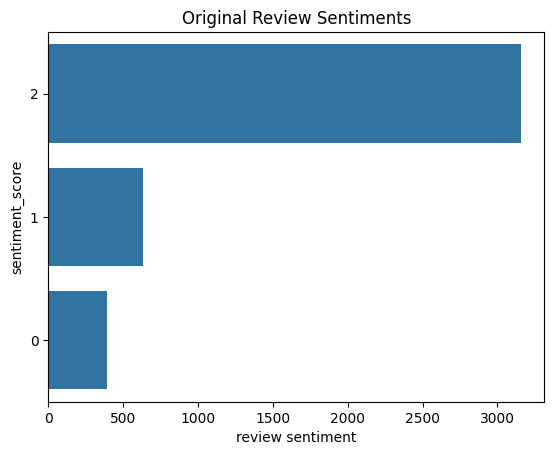

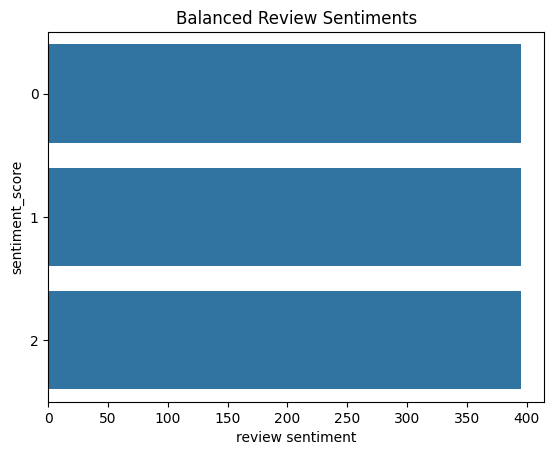

Original dataset size: 4182
Balanced dataset size: 1185


,site,user,review_target,review,score,max_score,norm_score,sentiment_score
0,Rotten Tomatoes,i M,Star Wars Episode Vii The Force Awakens,This movie was so lame with the female lead th...,1.0,5,0.2,0
1,Rotten Tomatoes,Daniel B,Talk To Me 2023,Over inflated rt score. Movie sucked,1.0,5,0.2,0
2,Rotten Tomatoes,Sebastian H,To Kill A Mockingbird,It was so boring that i busted all over the sc...,0.5,5,0.1,0
3,Rotten Tomatoes,Max H,No Country For Old Men,No Country for Old Men is often praised as a c...,0.5,5,0.1,0
4,Rotten Tomatoes,Glenn B,Get Out,Sucked with both lips!,0.5,5,0.1,0
...,...,...,...,...,...,...,...,...
1180,Rotten Tomatoes,Luciano S,Back To The Future,the movie was awesome it took the idea of time...,5.0,5,1.0,2
1181,Rotten Tomatoes,Steven N,Prisoners 2013,If you want to be kept on your toes for over 2...,4.5,5,0.9,2
1182,Rotten Tomatoes,Mathilde P,Prisoners 2013,"It's a great movie, but the clues are too obvi...",4.0,5,0.8,2
1183,Rotten Tomatoes,,Madea Goes To Jail,Wonderful Job Tyler Perry Keep Up The Good Work,5.0,5,1.0,2


Loading masked dataset:
    Loading existing dataset file @ rotten_tomatoes_masked_data.dt...
Loading reviews dataset:
    Loading existing dataset file @ rotten_tomatoes_reviews_data.dt...


In [46]:
reset, pretraining, finetuning = dataset_train_loop("rotten_tomatoes")

Masked pretraining:
    train_dataloader: (27 batches)
    test_dataloader: (92 batches)
    valid_dataloader: (14 batches)


{'input_ids': tensor([[ 101, 2307, 2143,  ...,    0,    0,    0],
         [ 101, 2025,  103,  ...,    0,    0,    0],
         [ 101, 2023, 2143,  ...,    0,    0,    0],
         ...,
         [ 101,  103,  103,  ...,    0,    0,    0],
         [ 101, 2023, 3185,  ...,    0,    0,    0],
         [ 101, 2028, 1997,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([[ 101, 2307, 2143,  ...,    0,    0,    0],
         [ 101, 2025, 6659,  ...,    0,    0,    0],
         [ 101, 2023, 2143,  ...,    0,    0,    0],
         ...,
         [ 101, 1996, 2630,  ...,    0,    0,    0],
         [ 101, 2023, 3185,  ...,    0,    0,    0],
         [ 101, 2028, 1997,  ...,    0,    0,    0]]),
 'original_text': ['Great film. Great acting. And some nice comed

Reviews training:
    train_dataloader: (8 batches)
    test_dataloader: (26 batches)
    valid_dataloader: (4 batches)


{'input_ids': tensor([[  101,  1045,  2113,  ...,     0,     0,     0],
         [  101,  9686,  3366,  ...,     0,     0,     0],
         [  101,  2009,  1005,  ...,     0,     0,     0],
         ...,
         [  101,  2307, 23873,  ...,     0,     0,     0],
         [  101,  6373,  2003,  ...,     0,     0,     0],
         [  101,  2383,  3427,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'original_text': ['I know it’s a very popular film, and I understand why so many people like it but I just don’t. It’s upsetting because I almost feel as if I didn’t give it a chance. I may return to this one in the future just to see my take on it then, but for now I didn’t care for it. The lady that played Sara Goldfarb gave a magnificent (and I’m not using that term 

Training start for 'rotten_tomatoes' finetuning...


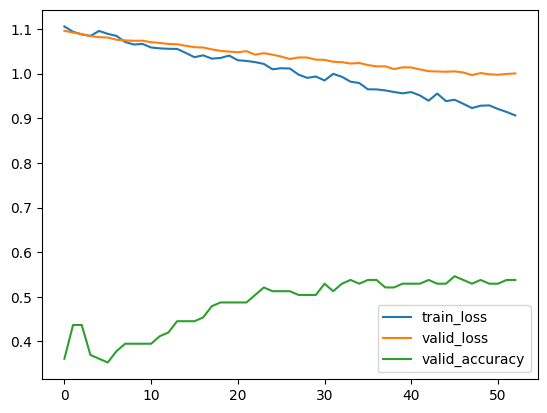

           : 100%|██████████| 4/4 [00:00<00:00, 13.17it/s, loss=1.09, num_correct=tensor(9, device='cuda:0')] 


           : 100%|██████████| 4/4 [00:00<00:00, 14.13it/s, loss=1.1, num_correct=tensor(6, device='cuda:0')]  


           {'epoch': 1, 'train_loss': 1.0937478691339493, 'valid_loss': 1.092015266418457, 'valid_accuracy': 0.4369747899159664}


           : 100%|██████████| 4/4 [00:00<00:00, 13.61it/s, loss=1.1, num_correct=tensor(7, device='cuda:0')]  


           {'epoch': 2, 'train_loss': 1.087798923254013, 'valid_loss': 1.0886600315570831, 'valid_accuracy': 0.4369747899159664}


           : 100%|██████████| 4/4 [00:00<00:00, 13.56it/s, loss=1.08, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 3, 'train_loss': 1.0844327807426453, 'valid_loss': 1.0842856764793396, 'valid_accuracy': 0.3697478991596639}


           : 100%|██████████| 4/4 [00:00<00:00, 13.89it/s, loss=1.07, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 4, 'train_loss': 1.0956668704748154, 'valid_loss': 1.081606686115265, 'valid_accuracy': 0.36134453781512604}


           : 100%|██████████| 4/4 [00:00<00:00, 13.79it/s, loss=1.1, num_correct=tensor(6, device='cuda:0')]  


           {'epoch': 5, 'train_loss': 1.089082956314087, 'valid_loss': 1.0809211134910583, 'valid_accuracy': 0.35294117647058826}


           : 100%|██████████| 4/4 [00:00<00:00, 13.81it/s, loss=1.06, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 6, 'train_loss': 1.0845348834991455, 'valid_loss': 1.075931429862976, 'valid_accuracy': 0.37815126050420167}


           : 100%|██████████| 4/4 [00:00<00:00, 13.75it/s, loss=1.08, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 7, 'train_loss': 1.0709641426801682, 'valid_loss': 1.074454426765442, 'valid_accuracy': 0.3949579831932773}


           : 100%|██████████| 4/4 [00:00<00:00, 13.84it/s, loss=1.08, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 8, 'train_loss': 1.065223976969719, 'valid_loss': 1.0735904276371002, 'valid_accuracy': 0.3949579831932773}


           : 100%|██████████| 4/4 [00:00<00:00, 12.58it/s, loss=1.1, num_correct=tensor(8, device='cuda:0')]  


           {'epoch': 9, 'train_loss': 1.0665545165538788, 'valid_loss': 1.0737495720386505, 'valid_accuracy': 0.3949579831932773}


           : 100%|██████████| 4/4 [00:00<00:00, 13.20it/s, loss=1.07, num_correct=tensor(8, device='cuda:0')] 


           {'epoch': 10, 'train_loss': 1.0585444420576096, 'valid_loss': 1.070358395576477, 'valid_accuracy': 0.3949579831932773}


           : 100%|██████████| 4/4 [00:00<00:00, 13.70it/s, loss=1.08, num_correct=tensor(7, device='cuda:0')] 


           {'epoch': 11, 'train_loss': 1.0566090196371078, 'valid_loss': 1.0688014328479767, 'valid_accuracy': 0.4117647058823529}


           : 100%|██████████| 4/4 [00:00<00:00, 13.75it/s, loss=1.06, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 12, 'train_loss': 1.05559291690588, 'valid_loss': 1.0664900541305542, 'valid_accuracy': 0.42016806722689076}


           : 100%|██████████| 4/4 [00:00<00:00, 13.92it/s, loss=1.08, num_correct=tensor(7, device='cuda:0')] 


           {'epoch': 13, 'train_loss': 1.0553346127271652, 'valid_loss': 1.0658190548419952, 'valid_accuracy': 0.44537815126050423}


           : 100%|██████████| 4/4 [00:00<00:00, 13.75it/s, loss=1.06, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 14, 'train_loss': 1.0463356673717499, 'valid_loss': 1.0624144077301025, 'valid_accuracy': 0.44537815126050423}


           : 100%|██████████| 4/4 [00:00<00:00, 13.79it/s, loss=1.05, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 15, 'train_loss': 1.0368006080389023, 'valid_loss': 1.0592065751552582, 'valid_accuracy': 0.44537815126050423}


           : 100%|██████████| 4/4 [00:00<00:00, 13.89it/s, loss=1.07, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 16, 'train_loss': 1.041003867983818, 'valid_loss': 1.0584892630577087, 'valid_accuracy': 0.453781512605042}


           : 100%|██████████| 4/4 [00:00<00:00, 13.70it/s, loss=1.04, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 17, 'train_loss': 1.0335796251893044, 'valid_loss': 1.0544028878211975, 'valid_accuracy': 0.4789915966386555}


           : 100%|██████████| 4/4 [00:00<00:00, 13.79it/s, loss=1.03, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 18, 'train_loss': 1.035071611404419, 'valid_loss': 1.050887107849121, 'valid_accuracy': 0.48739495798319327}


           : 100%|██████████| 4/4 [00:00<00:00, 14.08it/s, loss=1.03, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 19, 'train_loss': 1.0403661504387856, 'valid_loss': 1.0493351221084595, 'valid_accuracy': 0.48739495798319327}


           : 100%|██████████| 4/4 [00:00<00:00, 13.79it/s, loss=1.02, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 20, 'train_loss': 1.029943898320198, 'valid_loss': 1.047774463891983, 'valid_accuracy': 0.48739495798319327}


           : 100%|██████████| 4/4 [00:00<00:00, 13.74it/s, loss=1.07, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 21, 'train_loss': 1.0284099653363228, 'valid_loss': 1.0503210723400116, 'valid_accuracy': 0.48739495798319327}


           : 100%|██████████| 4/4 [00:00<00:00, 13.70it/s, loss=1, num_correct=tensor(14, device='cuda:0')]   


           {'epoch': 22, 'train_loss': 1.025731898844242, 'valid_loss': 1.0423592627048492, 'valid_accuracy': 0.5042016806722689}


           : 100%|██████████| 4/4 [00:00<00:00, 13.79it/s, loss=1.08, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 23, 'train_loss': 1.021779015660286, 'valid_loss': 1.0458645522594452, 'valid_accuracy': 0.5210084033613446}


           : 100%|██████████| 4/4 [00:00<00:00, 13.94it/s, loss=1.07, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 24, 'train_loss': 1.0097182542085648, 'valid_loss': 1.042416274547577, 'valid_accuracy': 0.5126050420168067}


           : 100%|██████████| 4/4 [00:00<00:00, 13.99it/s, loss=1.04, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 25, 'train_loss': 1.0120559707283974, 'valid_loss': 1.038268804550171, 'valid_accuracy': 0.5126050420168067}


           : 100%|██████████| 4/4 [00:00<00:00, 13.75it/s, loss=0.984, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 26, 'train_loss': 1.0114547684788704, 'valid_loss': 1.032746747136116, 'valid_accuracy': 0.5126050420168067}


           : 100%|██████████| 4/4 [00:00<00:00, 13.81it/s, loss=1.05, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 27, 'train_loss': 0.9978097602725029, 'valid_loss': 1.0361975133419037, 'valid_accuracy': 0.5042016806722689}


           : 100%|██████████| 4/4 [00:00<00:00, 13.70it/s, loss=1.05, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 28, 'train_loss': 0.990532174706459, 'valid_loss': 1.0360561609268188, 'valid_accuracy': 0.5042016806722689}


           : 100%|██████████| 4/4 [00:00<00:00, 13.64it/s, loss=1.01, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 29, 'train_loss': 0.9935090318322182, 'valid_loss': 1.031201645731926, 'valid_accuracy': 0.5042016806722689}


           : 100%|██████████| 4/4 [00:00<00:00, 14.04it/s, loss=1.03, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 30, 'train_loss': 0.9847098290920258, 'valid_loss': 1.0308499336242676, 'valid_accuracy': 0.5294117647058824}


           : 100%|██████████| 4/4 [00:00<00:00, 13.89it/s, loss=1.02, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 31, 'train_loss': 0.9994384199380875, 'valid_loss': 1.0266185998916626, 'valid_accuracy': 0.5126050420168067}


           : 100%|██████████| 4/4 [00:00<00:00, 13.84it/s, loss=1.04, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 32, 'train_loss': 0.9929020404815674, 'valid_loss': 1.0256533324718475, 'valid_accuracy': 0.5294117647058824}


           : 100%|██████████| 4/4 [00:00<00:00, 13.51it/s, loss=1.02, num_correct=tensor(11, device='cuda:0')] 


           {'epoch': 33, 'train_loss': 0.9819892644882202, 'valid_loss': 1.0226128101348877, 'valid_accuracy': 0.5378151260504201}


           : 100%|██████████| 4/4 [00:00<00:00, 13.84it/s, loss=1.07, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 34, 'train_loss': 0.9789538532495499, 'valid_loss': 1.0238769352436066, 'valid_accuracy': 0.5294117647058824}


           : 100%|██████████| 4/4 [00:00<00:00, 12.70it/s, loss=1.01, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 35, 'train_loss': 0.9648207128047943, 'valid_loss': 1.0192019641399384, 'valid_accuracy': 0.5378151260504201}


           : 100%|██████████| 4/4 [00:00<00:00, 13.29it/s, loss=0.991, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 36, 'train_loss': 0.964648500084877, 'valid_loss': 1.0162593126296997, 'valid_accuracy': 0.5378151260504201}


           : 100%|██████████| 4/4 [00:00<00:00, 13.62it/s, loss=1.02, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 37, 'train_loss': 0.9624679535627365, 'valid_loss': 1.0164006650447845, 'valid_accuracy': 0.5210084033613446}


           : 100%|██████████| 4/4 [00:00<00:00, 13.75it/s, loss=0.95, num_correct=tensor(16, device='cuda:0')] 


           {'epoch': 38, 'train_loss': 0.9588349014520645, 'valid_loss': 1.0102605521678925, 'valid_accuracy': 0.5210084033613446}


           : 100%|██████████| 4/4 [00:00<00:00, 13.38it/s, loss=1.01, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 39, 'train_loss': 0.9558877721428871, 'valid_loss': 1.0140729248523712, 'valid_accuracy': 0.5294117647058824}


           : 100%|██████████| 4/4 [00:00<00:00, 13.89it/s, loss=1.03, num_correct=tensor(12, device='cuda:0')] 


           {'epoch': 40, 'train_loss': 0.9586840569972992, 'valid_loss': 1.0137518346309662, 'valid_accuracy': 0.5294117647058824}


           : 100%|██████████| 4/4 [00:00<00:00, 13.79it/s, loss=0.986, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 41, 'train_loss': 0.9510566741228104, 'valid_loss': 1.009512111544609, 'valid_accuracy': 0.5294117647058824}


           : 100%|██████████| 4/4 [00:00<00:00, 13.79it/s, loss=0.969, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 42, 'train_loss': 0.9392655566334724, 'valid_loss': 1.0055104345083237, 'valid_accuracy': 0.5378151260504201}


           : 100%|██████████| 4/4 [00:00<00:00, 12.70it/s, loss=0.99, num_correct=tensor(13, device='cuda:0')] 


           {'epoch': 43, 'train_loss': 0.9553764536976814, 'valid_loss': 1.0047733187675476, 'valid_accuracy': 0.5294117647058824}


           : 100%|██████████| 4/4 [00:00<00:00, 13.51it/s, loss=1, num_correct=tensor(13, device='cuda:0')]   


           {'epoch': 44, 'train_loss': 0.9383535608649254, 'valid_loss': 1.0041828006505966, 'valid_accuracy': 0.5294117647058824}


           : 100%|██████████| 4/4 [00:00<00:00, 13.61it/s, loss=1.02, num_correct=tensor(12, device='cuda:0')] 


           {'epoch': 45, 'train_loss': 0.941462479531765, 'valid_loss': 1.005079448223114, 'valid_accuracy': 0.5462184873949579}


           : 100%|██████████| 4/4 [00:00<00:00, 13.89it/s, loss=0.997, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 46, 'train_loss': 0.9324294179677963, 'valid_loss': 1.002605065703392, 'valid_accuracy': 0.5378151260504201}


           : 100%|██████████| 4/4 [00:00<00:00, 13.89it/s, loss=0.946, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 47, 'train_loss': 0.9229036644101143, 'valid_loss': 0.9966839998960495, 'valid_accuracy': 0.5294117647058824}


           : 100%|██████████| 4/4 [00:00<00:00, 13.79it/s, loss=1.02, num_correct=tensor(13, device='cuda:0')] 


           {'epoch': 48, 'train_loss': 0.9281539767980576, 'valid_loss': 1.0012779980897903, 'valid_accuracy': 0.5378151260504201}


           : 100%|██████████| 4/4 [00:00<00:00, 13.94it/s, loss=0.991, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 49, 'train_loss': 0.9288519322872162, 'valid_loss': 0.9985279440879822, 'valid_accuracy': 0.5294117647058824}


           : 100%|██████████| 4/4 [00:00<00:00, 13.79it/s, loss=1.02, num_correct=tensor(12, device='cuda:0')] 


           {'epoch': 50, 'train_loss': 0.9207904636859894, 'valid_loss': 0.9974555671215057, 'valid_accuracy': 0.5294117647058824}


           : 100%|██████████| 4/4 [00:00<00:00, 13.61it/s, loss=1.04, num_correct=tensor(10, device='cuda:0')] 


           {'epoch': 51, 'train_loss': 0.9141001477837563, 'valid_loss': 0.9993069469928741, 'valid_accuracy': 0.5378151260504201}


           : 100%|██████████| 4/4 [00:00<00:00, 13.84it/s, loss=1.06, num_correct=tensor(9, device='cuda:0')]  


           {'epoch': 52, 'train_loss': 0.9063702449202538, 'valid_loss': 1.000452846288681, 'valid_accuracy': 0.5378151260504201}
Stopping early...


In [47]:
reset(train_bert_in_finetune=False)
pretraining(pretrained_model_name="distilbert/distilbert-base-uncased")
finetuning(stop_delta_loss=0.005)

## Combined (MyAnimeList, Steam, Metacritic, Rotten Tomatoes)

Training BERT on all 4 platforms.

Loaded training config:


{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'pretrained_model_name': '', 'name': 'myanimelist-steam-metacritic-rotten_tomatoes', 'class_names': ['negative'

Loaded myanimelist-steam-metacritic-rotten_tomatoes:


,site,user,review_target,review,score,max_score
0,Rotten Tomatoes,Oaklee D,The Lego Ninjago Movie,A forgettable kids film.,2.5,5
1,steam,Andro,Total War: WARHAMMER III,I love this game but absolutely despise what C...,1.0,1
2,steam,Cheating Death,Call of Duty®,"endless ""packet burst"" server related issues. ...",0.0,1
3,MyAnimeList,ravenagotica,Nausicaä of the Valley of the Wind,Nausicaä of the Valley of the Wind is a film t...,10.0,10
4,MyAnimeList,longshoremanX,Clannad: After Story,there comes a time in every anime fan's life w...,10.0,10
...,...,...,...,...,...,...
47536,steam,Hershey Squirts,Call of Duty®: Black Ops II,Lower the price,1.0,1
47537,metacritic,Cj_606,a-short-hike,Relaxing and fun adventure gaming experience. ...,8.0,10
47538,metacritic,mrelliscool,super-mario-64,this is a very fun game! but.... its very unfa...,8.0,10
47539,steam,Camden,DayZ,I've played lots of DayZ. And I've enjoyed mos...,0.0,1


C:\Users\Alan\AppData\Local\Temp\ipykernel_1148\1993628425.py:471: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = g.apply(lambda x: x.sample(min_group_size)).reset_index(drop=True)


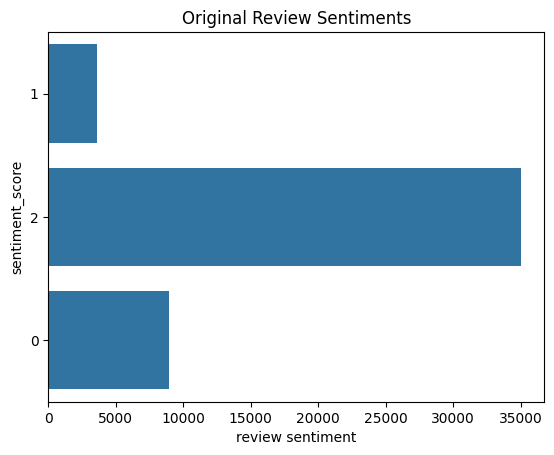

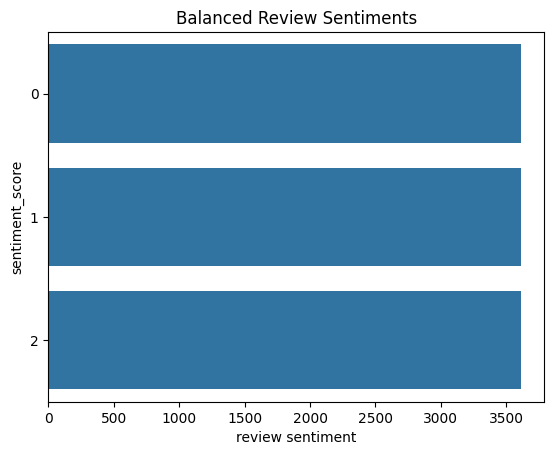

Original dataset size: 47541
Balanced dataset size: 10830


,site,user,review_target,review,score,max_score,norm_score,sentiment_score
0,MyAnimeList,Zecomm,Naruto,Naruto has to be the most over rated anime in ...,2.0,10,0.2,0
1,steam,crYpto scammer,PGA TOUR 2K25,I found 2k23 more enjoyable to play. There rea...,0.0,1,0.0,0
2,metacritic,sdyk2019,the-sims-4,This game is horrible on so many levels. Ok if...,1.0,10,0.1,0
3,MyAnimeList,Polyphemus,Great Teacher Onizuka,"Great Teacher Onizuka had some potential, but ...",3.0,10,0.3,0
4,MyAnimeList,thumpz99,Dr. Stone,What started out somewhat strong declined stea...,2.0,10,0.2,0
...,...,...,...,...,...,...,...,...
10825,steam,Bree-chan,THRONE AND LIBERTY,After 60 hours the first week I have to recomm...,1.0,1,1.0,2
10826,Rotten Tomatoes,,Kingdom Of The Planet Of The Apes,"pacing lacked, but great overall. looking forw...",4.0,5,0.8,2
10827,steam,Netoo,Ready or Not,"Police! Hands up.Put your hands up!Hands up, D...",1.0,1,1.0,2
10828,steam,Felinestep,THRONE AND LIBERTY,It's a very beautiful game. The music especial...,1.0,1,1.0,2


Loading masked dataset:
    Loading existing dataset file @ myanimelist-steam-metacritic-rotten_tomatoes_masked_data.dt...
    Error loading dataset file: [Errno 2] No such file or directory: 'c:\\Users\\Alan\\Desktop\\Open_Source\\BERT-TLSA-paper/data/myanimelist-steam-metacritic-rotten_tomatoes_masked_data.dt'
    Creating new dataset file @ myanimelist-steam-metacritic-rotten_tomatoes_masked_data.dt...
Loading reviews dataset:
    Loading existing dataset file @ myanimelist-steam-metacritic-rotten_tomatoes_reviews_data.dt...
    Error loading dataset file: [Errno 2] No such file or directory: 'c:\\Users\\Alan\\Desktop\\Open_Source\\BERT-TLSA-paper/data/myanimelist-steam-metacritic-rotten_tomatoes_reviews_data.dt'
    Creating new dataset file @ myanimelist-steam-metacritic-rotten_tomatoes_reviews_data.dt...


In [53]:
reset, pretraining, finetuning = dataset_train_loop(["myanimelist", "steam", "metacritic", "rotten_tomatoes"])

Masked pretraining:
    train_dataloader: (298 batches)
    test_dataloader: (1040 batches)
    valid_dataloader: (149 batches)


{'input_ids': tensor([[  101,  8915,   103,  ...,     0,     0,     0],
         [  101,  2023,  8750,  ...,  1037,   103,   102],
         [  101, 21025, 24163,  ...,     0,     0,     0],
         ...,
         [  101,   103,  4339,  ...,  1000,  1010,   102],
         [  101,  1037,  2146,  ...,     0,     0,     0],
         [  101,  1031,  2023,  ...,  2007,  2068,   102]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'labels': tensor([[  101,  8915, 18886,  ...,     0,     0,     0],
         [  101,  2023,  8750,  ...,  1037,  8292,   102],
         [  101, 21025, 24163,  ...,     0,     0,     0],
         ...,
         [  101,  1045,  4339,  ...,  1000,  1010,   102],
         [  101,  1037,  2146,  ...,     0,     0,     0],
         [  101,  1031,  2023,  ...,  2007,  2068,   1

Reviews training:
    train_dataloader: (68 batches)
    test_dataloader: (237 batches)
    valid_dataloader: (34 batches)


{'input_ids': tensor([[  101,  2005,  2070,  ...,     0,     0,     0],
         [  101,  2387,  2111,  ...,     0,     0,     0],
         [  101,  1045,  2572,  ...,     0,     0,     0],
         ...,
         [  101,  2000,  4088,  ...,  1012,  1996,   102],
         [  101,  2023,  2003,  ...,  2217,  3494,   102],
         [  101, 27594,  2545,  ...,  2006,  2256,   102]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'original_text': ["For some reason the game doesn't save automatically, nor am I able to save manually. I've lost several hours of gameplay so far, and I'm deadass considering suicide atp... I've already had to replay 4 chapters once, and this time I'll have to replay 8 whole chapters because the game ♥♥♥♥♥♥♥ crashed:,) For your own mental health, wait until the issue g

Training start for 'myanimelist-steam-metacritic-rotten_tomatoes' finetuning...


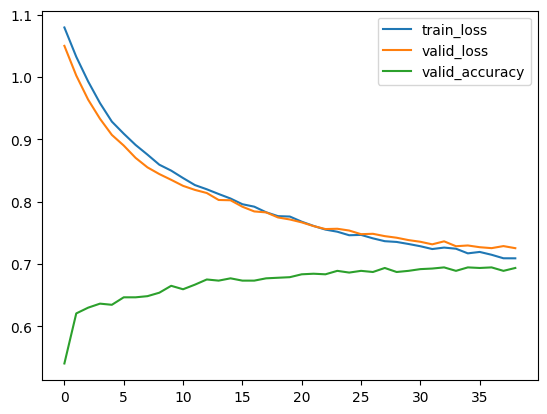

           : 100%|██████████| 34/34 [00:02<00:00, 12.40it/s, loss=1.06, num_correct=tensor(14, device='cuda:0')]


           : 100%|██████████| 34/34 [00:02<00:00, 12.93it/s, loss=0.986, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 1, 'train_loss': 1.0323956056552774, 'valid_loss': 1.0023006113136517, 'valid_accuracy': 0.6204986149584487}


           : 100%|██████████| 34/34 [00:02<00:00, 12.98it/s, loss=0.905, num_correct=tensor(19, device='cuda:0')]


           {'epoch': 2, 'train_loss': 0.9928458034992218, 'valid_loss': 0.9636438261060154, 'valid_accuracy': 0.6297322253000923}


           : 100%|██████████| 34/34 [00:02<00:00, 12.97it/s, loss=0.928, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 3, 'train_loss': 0.9580525335143594, 'valid_loss': 0.932902949697831, 'valid_accuracy': 0.6361957525392429}


           : 100%|██████████| 34/34 [00:02<00:00, 12.95it/s, loss=0.897, num_correct=tensor(18, device='cuda:0')]


           {'epoch': 4, 'train_loss': 0.9283580736202353, 'valid_loss': 0.9069942025577321, 'valid_accuracy': 0.6343490304709142}


           : 100%|██████████| 34/34 [00:02<00:00, 12.97it/s, loss=0.805, num_correct=tensor(22, device='cuda:0')]


           {'epoch': 5, 'train_loss': 0.9090073985211989, 'valid_loss': 0.8899493340183707, 'valid_accuracy': 0.6463527239150508}


           : 100%|██████████| 34/34 [00:02<00:00, 12.50it/s, loss=0.834, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 6, 'train_loss': 0.8908852373852449, 'valid_loss': 0.8701402457321391, 'valid_accuracy': 0.6463527239150508}


           : 100%|██████████| 34/34 [00:02<00:00, 12.24it/s, loss=0.811, num_correct=tensor(18, device='cuda:0')]


           {'epoch': 7, 'train_loss': 0.8753570931799272, 'valid_loss': 0.8549263845471775, 'valid_accuracy': 0.6481994459833795}


           : 100%|██████████| 34/34 [00:02<00:00, 12.56it/s, loss=0.869, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 8, 'train_loss': 0.8591896015055039, 'valid_loss': 0.8441553799545064, 'valid_accuracy': 0.6537396121883656}


           : 100%|██████████| 34/34 [00:02<00:00, 12.88it/s, loss=0.906, num_correct=tensor(18, device='cuda:0')]


           {'epoch': 9, 'train_loss': 0.8496670863207649, 'valid_loss': 0.8349218824330498, 'valid_accuracy': 0.6648199445983379}


           : 100%|██████████| 34/34 [00:02<00:00, 12.89it/s, loss=0.775, num_correct=tensor(19, device='cuda:0')]


           {'epoch': 10, 'train_loss': 0.8377788268467959, 'valid_loss': 0.8252464340013617, 'valid_accuracy': 0.6592797783933518}


           : 100%|██████████| 34/34 [00:02<00:00, 12.69it/s, loss=0.676, num_correct=tensor(22, device='cuda:0')]


           {'epoch': 11, 'train_loss': 0.8264940468704, 'valid_loss': 0.8187484039979822, 'valid_accuracy': 0.6666666666666666}


           : 100%|██████████| 34/34 [00:02<00:00, 11.53it/s, loss=0.851, num_correct=tensor(18, device='cuda:0')]


           {'epoch': 12, 'train_loss': 0.8197323294246898, 'valid_loss': 0.8137549021664787, 'valid_accuracy': 0.6749769159741459}


           : 100%|██████████| 34/34 [00:02<00:00, 12.66it/s, loss=0.764, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 13, 'train_loss': 0.8121648685020559, 'valid_loss': 0.8025780933744767, 'valid_accuracy': 0.6731301939058172}


           : 100%|██████████| 34/34 [00:02<00:00, 12.75it/s, loss=0.914, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 14, 'train_loss': 0.8049165150698494, 'valid_loss': 0.8021090065731722, 'valid_accuracy': 0.6768236380424746}


           : 100%|██████████| 34/34 [00:02<00:00, 12.51it/s, loss=0.763, num_correct=tensor(19, device='cuda:0')]


           {'epoch': 15, 'train_loss': 0.7957667375312132, 'valid_loss': 0.791747345643885, 'valid_accuracy': 0.6731301939058172}


           : 100%|██████████| 34/34 [00:02<00:00, 12.60it/s, loss=0.841, num_correct=tensor(18, device='cuda:0')]


           {'epoch': 16, 'train_loss': 0.7918313434895348, 'valid_loss': 0.7841917048482334, 'valid_accuracy': 0.6731301939058172}


           : 100%|██████████| 34/34 [00:02<00:00, 12.73it/s, loss=0.924, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 17, 'train_loss': 0.782855329268119, 'valid_loss': 0.7826605456716874, 'valid_accuracy': 0.6768236380424746}


           : 100%|██████████| 34/34 [00:02<00:00, 12.83it/s, loss=0.835, num_correct=tensor(21, device='cuda:0')]


           {'epoch': 18, 'train_loss': 0.7766306785976186, 'valid_loss': 0.77454433371039, 'valid_accuracy': 0.6777469990766389}


           : 100%|██████████| 34/34 [00:02<00:00, 12.81it/s, loss=0.803, num_correct=tensor(18, device='cuda:0')]


           {'epoch': 19, 'train_loss': 0.7759814735721139, 'valid_loss': 0.7712697351680082, 'valid_accuracy': 0.6786703601108033}


           : 100%|██████████| 34/34 [00:02<00:00, 12.89it/s, loss=0.736, num_correct=tensor(19, device='cuda:0')]


           {'epoch': 20, 'train_loss': 0.7677180881009382, 'valid_loss': 0.7666321887689478, 'valid_accuracy': 0.6832871652816251}


           : 100%|██████████| 34/34 [00:02<00:00, 12.80it/s, loss=0.828, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 21, 'train_loss': 0.7609325568465626, 'valid_loss': 0.7606665439465466, 'valid_accuracy': 0.6842105263157895}


           : 100%|██████████| 34/34 [00:02<00:00, 12.73it/s, loss=0.639, num_correct=tensor(23, device='cuda:0')]


           {'epoch': 22, 'train_loss': 0.7550307617467993, 'valid_loss': 0.7558812972377328, 'valid_accuracy': 0.6832871652816251}


           : 100%|██████████| 34/34 [00:02<00:00, 12.86it/s, loss=0.845, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 23, 'train_loss': 0.7516443764462191, 'valid_loss': 0.7563827353365281, 'valid_accuracy': 0.6888273314866112}


           : 100%|██████████| 34/34 [00:02<00:00, 12.50it/s, loss=0.478, num_correct=tensor(24, device='cuda:0')]


           {'epoch': 24, 'train_loss': 0.7459692998844034, 'valid_loss': 0.7535281382939395, 'valid_accuracy': 0.6860572483841182}


           : 100%|██████████| 34/34 [00:02<00:00, 12.84it/s, loss=0.69, num_correct=tensor(20, device='cuda:0')] 


           {'epoch': 25, 'train_loss': 0.7465265428318697, 'valid_loss': 0.7476975900285384, 'valid_accuracy': 0.6888273314866112}


           : 100%|██████████| 34/34 [00:02<00:00, 12.88it/s, loss=0.766, num_correct=tensor(17, device='cuda:0')]


           {'epoch': 26, 'train_loss': 0.7409875603283153, 'valid_loss': 0.7482767631025875, 'valid_accuracy': 0.6869806094182825}


           : 100%|██████████| 34/34 [00:02<00:00, 12.72it/s, loss=0.714, num_correct=tensor(20, device='cuda:0')]


           {'epoch': 27, 'train_loss': 0.7364240823423162, 'valid_loss': 0.7445361140896293, 'valid_accuracy': 0.6934441366574331}


           : 100%|██████████| 34/34 [00:02<00:00, 12.59it/s, loss=0.614, num_correct=tensor(22, device='cuda:0')]


           {'epoch': 28, 'train_loss': 0.7352154855342472, 'valid_loss': 0.7419819884440478, 'valid_accuracy': 0.6869806094182825}


           : 100%|██████████| 34/34 [00:02<00:00, 12.66it/s, loss=0.579, num_correct=tensor(21, device='cuda:0')]


           {'epoch': 29, 'train_loss': 0.7319354125682045, 'valid_loss': 0.7381820766364827, 'valid_accuracy': 0.6888273314866112}


           : 100%|██████████| 34/34 [00:02<00:00, 12.72it/s, loss=0.632, num_correct=tensor(21, device='cuda:0')]


           {'epoch': 30, 'train_loss': 0.7283226961598677, 'valid_loss': 0.735487748594845, 'valid_accuracy': 0.6915974145891043}


           : 100%|██████████| 34/34 [00:02<00:00, 12.48it/s, loss=0.808, num_correct=tensor(19, device='cuda:0')]


           {'epoch': 31, 'train_loss': 0.7238358381916495, 'valid_loss': 0.7313754278070786, 'valid_accuracy': 0.6925207756232687}


           : 100%|██████████| 34/34 [00:02<00:00, 12.95it/s, loss=0.609, num_correct=tensor(20, device='cuda:0')]


           {'epoch': 32, 'train_loss': 0.7261708396322587, 'valid_loss': 0.7362007533802706, 'valid_accuracy': 0.6943674976915974}


           : 100%|██████████| 34/34 [00:02<00:00, 12.79it/s, loss=0.752, num_correct=tensor(18, device='cuda:0')]


           {'epoch': 33, 'train_loss': 0.724356039043735, 'valid_loss': 0.7283533531076768, 'valid_accuracy': 0.6888273314866112}


           : 100%|██████████| 34/34 [00:02<00:00, 12.52it/s, loss=0.663, num_correct=tensor(20, device='cuda:0')]


           {'epoch': 34, 'train_loss': 0.7168962933561381, 'valid_loss': 0.7295587588759029, 'valid_accuracy': 0.6943674976915974}


           : 100%|██████████| 34/34 [00:02<00:00, 12.53it/s, loss=0.743, num_correct=tensor(20, device='cuda:0')]


           {'epoch': 35, 'train_loss': 0.7191799204139149, 'valid_loss': 0.7267733873689876, 'valid_accuracy': 0.6934441366574331}


           : 100%|██████████| 34/34 [00:03<00:00, 11.18it/s, loss=0.608, num_correct=tensor(20, device='cuda:0')]


           {'epoch': 36, 'train_loss': 0.714636809685651, 'valid_loss': 0.7252670596627628, 'valid_accuracy': 0.6943674976915974}


           : 100%|██████████| 34/34 [00:02<00:00, 12.12it/s, loss=0.61, num_correct=tensor(20, device='cuda:0')] 


           {'epoch': 37, 'train_loss': 0.7090078368782997, 'valid_loss': 0.7285654439645655, 'valid_accuracy': 0.6888273314866112}


           : 100%|██████████| 34/34 [00:02<00:00, 12.09it/s, loss=0.503, num_correct=tensor(23, device='cuda:0')]


           {'epoch': 38, 'train_loss': 0.7089384662754395, 'valid_loss': 0.7252141333678189, 'valid_accuracy': 0.6934441366574331}
Stopping early...


In [54]:
reset(train_bert_in_finetune=False)
pretraining(pretrained_model_name="distilbert/distilbert-base-uncased")
finetuning(stop_delta_loss=0.005)